# Pipeline para Selección de variables

<B>Objetivo:</B> <br> 
Realizar Feature Selection mediante la aplicación de los algoritmos Lasso y Random Forest para obtener un ranking de variables según su relevancia y  sirva de input para el análisis de selección de variables.<br>

<B>Especificaciones:</B> 
Se ralizan los siguientes pasos:
<ol>
<li> Preprocesamiento de la data y laggings </li>
<li> Analisis de correlacion</li>
<li> Analisis iterativo de Variance Inflation Factor (VIF)</li>
<li> Modelo de Lasso Regression</li>
<li> Modelo de Random Forest Regressor</li>
</ol>

<B>Consideraciones:</B> 
- Se toma la foto de los clientes al 31.12.2022
- Tablas utilizadas para la construcción:
1. Tabla Buró: Abril2022 - Enero 2023
2. Tabla Desembolsos: Junio 2021 - Diciembre 2022
3. Tabla Saldos: Junio - Diciembre 2022
4. Tabla Margen Orginal: Enero - Diciembre 2022
5. Tabla Cantidad Tipo Productos y Cantidad de Productos: al 31.12.2022
6. Tabla Clientes: Foto de cliente al momento de cada solicitud, se tiene la solicitud más reciente de cada clientes entre 2018-2022. Salvo la columna 'TieneUsuarioDigital' que data de febrero 2023.  
7. Tabla IdPrestamo vs IdSolicitud: Permite identificar si IdSolicitud desembolsó o no.

# 2. CONFIGURACIÓN 

In [1]:
import time
time_start = time.time()

In [1]:
# Importamos librerias para el analisis
import numpy as np
import pandas as pd
from datetime import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import gc
import openpyxl
import warnings
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.regressor import ResidualsPlot


# Configuraciones para visualizar la data
pd.options.display.max_columns = 100
pd.options.display.max_rows = 999
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 100
# Configuraciones para ignorar los warnings
warnings.filterwarnings(action='ignore') 


### INPUTS

In [2]:
# Definimos parámetros

## Definimos parámetros de periodo de últimos 3 meses
periodo_3m_ini = '2022-07-31'
periodo_3m_fin = '2022-12-31'

## Definimos parámetros de periodo últimos 6 meses
periodo_6m_ini = "2022-07-01"
periodo_6m_fin = "2022-12-31"

## Listado de 3 últimos meses
list_3m = ['202210', '202211', '202212']

## Listado de 6 últimos meses
list_6m = ['202207', '202208', '202209', '202210', '202211', '202212']

## Fecha de procesamiento para variables
fecha_corte = datetime(2022, 12, 31)

## Definimos competidores directos de Interconsumo
competidores = ['BANCO DE DESARROLLO RURAL, S. A.', 'BANCO DE ANTIGUA, S. A.', 'BANCO AZTECA DE GUATEMALA, S. A.']

### OUTPUTS

In [3]:
# Definimos los outputs
ruta_clientes_output =  r'C:\Users\PS342TS\OneDrive - EY\Interconsumo\Clustering\2. Selección de Variables Cuantitativo\RANKING_VARIABLES_31.03.2023.csv'

# 3. LECTURA, ANÁLISIS Y CONSTRUCCIÓN VARIABLES

## 3.0. TABLA MAESTRA

Data comprendida entre `2022-04 al 2023-01`

### LECTURA

In [4]:
# Leemos la Tabla Maestra
ruta_maestra = r'C:\Users\PS342TS\OneDrive - EY\Interconsumo\Clustering\2. Selección de Variables Cuantitativo\BD_SELECCION_VARIABLES_2023.03.31.csv'

dtype_maestra = {'IdCliente': str,
'SALDO_TOTAL_SF': np.float32,
'SHARE_OF_WALLET': np.float32,
'CANTIDAD_ENTIDADES_CON_DEUDA': np.int32,
'CUPO_TC_SF': np.float32,
'CANT_CREDITOS_VIGENTES_SF': np.float32,
'MONTO_DESEMB_TOTAL_SF_ULT6M': np.float32,
'SALDO_PREST_PRENDARIO_SF': np.float32,
'SALDO_PREST_HIPOTECARIO_SF': np.float32,
'SALDO_PREST_FIDUCIARIO_SF': np.float32,
'SHARE_OF_WALLET_FIDUCIARIO': np.float32,
'SALDO_PREST_FIDUC_COMPETIDORES': np.float32,
'CANT_DESEMBOLSOS_IC_6MESES': np.float32,
'MONTO_DESEM_PRESTAMOS_IC_6MESES': np.float32,
'CANT_DESEMB_IC_6MESES': np.float32,
'SALDO_SUM_IC_6MESES': np.float32,
'SALDO_PROM_IC_6MESES': np.float32,
'MARGEN_ORDINAL_PROM_6MESES': np.float32,
'CANT_TIPO_PRODUCTOS_ACTIVOS': np.float32,
'CANT_PRODUCTOS_ACTIVOS': np.float32,
'TIEMPO_LABORANDO_MESES': np.float32,
'EDAD_ANIOS': np.float32,
'INGRESOS_QUETZALES': np.float32,
'ANTIGUEDAD_IC_CORTE': np.float32,
'FLAG_USUARIO_DIGITAL': np.int32
}

df_maestra = pd.read_csv(ruta_maestra, dtype=dtype_maestra, parse_dates=[1,16,19,22], sep=";")

# Visualizamos las primeras filas
df_maestra.head()

,IdCliente,fechaSaldos,SALDO_TOTAL_SF,SHARE_OF_WALLET,CANTIDAD_ENTIDADES_CON_DEUDA,CUPO_TC_SF,CANT_CREDITOS_VIGENTES_SF,MONTO_DESEMB_TOTAL_SF_ULT6M,SALDO_PREST_PRENDARIO_SF,SALDO_PREST_HIPOTECARIO_SF,SALDO_PREST_FIDUCIARIO_SF,SHARE_OF_WALLET_FIDUCIARIO,SALDO_PREST_FIDUC_COMPETIDORES,Periodo,CANT_DESEMBOLSOS_IC_6MESES,MONTO_DESEM_PRESTAMOS_IC_6MESES,Periodo_Fecha_x,CANT_DESEMB_IC_6MESES,SALDO_SUM_IC_6MESES,Fecha,SALDO_PROM_IC_6MESES,MARGEN_ORDINAL_PROM_6MESES,Periodo_Fecha_y,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL
0,10000,2022-04-30,"71,825.81",0.00,3,"59,244.31",2.00,"4,000.00",0.00,0.00,"29,134.41",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0
1,10000,2022-05-31,"75,545.34",0.00,3,"59,244.31",2.00,"4,000.00",0.00,0.00,"28,631.43",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0
2,10000,2022-06-30,"85,612.27",0.00,4,"101,969.24",3.00,"8,000.00",0.00,0.00,"32,120.90",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0
3,10000,2022-07-31,"98,462.57",0.00,4,"101,969.24",3.00,"8,000.00",0.00,0.00,"31,316.34",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0
4,10000,2022-08-31,"131,537.64",0.00,4,"101,969.24",3.00,"4,000.00",0.00,0.00,"31,316.34",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0


### ANALISIS

In [5]:
# Obtenemos estadísticos la data y conteo de nulos
count_nan = df_maestra.isnull().sum(axis=0)
df_maestra.describe().append(pd.Series(count_nan, name='count_nan'))

,SALDO_TOTAL_SF,SHARE_OF_WALLET,CANTIDAD_ENTIDADES_CON_DEUDA,CUPO_TC_SF,CANT_CREDITOS_VIGENTES_SF,MONTO_DESEMB_TOTAL_SF_ULT6M,SALDO_PREST_PRENDARIO_SF,SALDO_PREST_HIPOTECARIO_SF,SALDO_PREST_FIDUCIARIO_SF,SHARE_OF_WALLET_FIDUCIARIO,SALDO_PREST_FIDUC_COMPETIDORES,Periodo,CANT_DESEMBOLSOS_IC_6MESES,MONTO_DESEM_PRESTAMOS_IC_6MESES,CANT_DESEMB_IC_6MESES,SALDO_SUM_IC_6MESES,SALDO_PROM_IC_6MESES,MARGEN_ORDINAL_PROM_6MESES,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL,Fecha,IdCliente,Periodo_Fecha_x,Periodo_Fecha_y,fechaSaldos
count,"924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00","924,961.00",NaN,NaN,NaN,NaN,NaN
mean,"44,748.41",0.26,2.05,"19,537.91",1.88,"12,861.33","1,317.91","6,703.50","25,265.88",0.30,"6,624.88","5,432.52",0.03,131.29,0.94,"5,719.04",953.15,19.87,0.40,0.40,86.22,34.79,"4,824.18","1,895.80",0.54,NaN,NaN,NaN,NaN,NaN
std,"133,011.44",0.41,1.28,"136,618.58",2.03,"57,226.21","14,758.77","101,810.87","55,085.86",0.44,"21,004.20","32,695.39",0.17,"1,084.53",1.85,"16,361.12","2,722.01",38.80,0.56,0.55,80.76,10.38,"3,418.75","1,629.10",0.50,NaN,NaN,NaN,NaN,NaN
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"-2,582.74",0.00,0.00,1.00,18.00,"1,000.00",0.00,0.00,NaN,NaN,NaN,NaN,NaN
25%,"4,598.15",0.00,1.00,0.00,1.00,0.00,0.00,0.00,355.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00,27.00,"3,150.00",667.00,0.00,NaN,NaN,NaN,NaN,NaN
50%,"14,088.10",0.00,2.00,"4,000.00",2.00,0.00,0.00,0.00,"7,391.25",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,60.00,32.00,"4,000.00","1,486.00",1.00,NaN,NaN,NaN,NaN,NaN
75%,"43,526.21",0.48,3.00,"14,800.00",2.00,"7,471.77",0.00,0.00,"24,853.80",1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.05,1.00,1.00,120.00,41.00,"5,000.00","2,420.00",1.00,NaN,NaN,NaN,NaN,NaN
max,"21,465,032.00",1.00,13.00,"19,266,372.00",111.00,"12,000,000.00","918,362.00","21,179,256.00","3,591,514.00",1.00,"850,000.00","202,212.00",5.00,"52,500.00",6.00,"486,563.69","81,093.95","1,855.00",3.00,3.00,606.00,70.00,"50,000.00","8,950.00",1.00,NaN,NaN,NaN,NaN,NaN
count_nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [6]:
# Revisamos los periodos de data
df_maestra.fechaSaldos.unique()

array(['2022-04-30T00:00:00.000000000', '2022-05-31T00:00:00.000000000',
       '2022-06-30T00:00:00.000000000', '2022-07-31T00:00:00.000000000',
       '2022-08-31T00:00:00.000000000', '2022-10-31T00:00:00.000000000',
       '2022-11-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000',
       '2022-09-30T00:00:00.000000000', '2023-01-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

### CONSTRUCCIÓN VARIABLES LAG

In [7]:
# Visualizamos las columnas de la tabla consolidada
df_maestra.columns

Index(['IdCliente', 'fechaSaldos', 'SALDO_TOTAL_SF', 'SHARE_OF_WALLET',
       'CANTIDAD_ENTIDADES_CON_DEUDA', 'CUPO_TC_SF',
       'CANT_CREDITOS_VIGENTES_SF', 'MONTO_DESEMB_TOTAL_SF_ULT6M',
       'SALDO_PREST_PRENDARIO_SF', 'SALDO_PREST_HIPOTECARIO_SF',
       'SALDO_PREST_FIDUCIARIO_SF', 'SHARE_OF_WALLET_FIDUCIARIO',
       'SALDO_PREST_FIDUC_COMPETIDORES', 'Periodo',
       'CANT_DESEMBOLSOS_IC_6MESES', 'MONTO_DESEM_PRESTAMOS_IC_6MESES',
       'Periodo_Fecha_x', 'CANT_DESEMB_IC_6MESES', 'SALDO_SUM_IC_6MESES',
       'Fecha', 'SALDO_PROM_IC_6MESES', 'MARGEN_ORDINAL_PROM_6MESES',
       'Periodo_Fecha_y', 'CANT_TIPO_PRODUCTOS_ACTIVOS',
       'CANT_PRODUCTOS_ACTIVOS', 'TIEMPO_LABORANDO_MESES', 'EDAD_ANIOS',
       'INGRESOS_QUETZALES', 'ANTIGUEDAD_IC_CORTE', 'FLAG_USUARIO_DIGITAL'],
      dtype='object')

In [8]:
# Seteamos las columnas que tendrían valores "futuros" para el modelo
cols_lag = [ 'SALDO_TOTAL_SF', 'SHARE_OF_WALLET',
       'CANTIDAD_ENTIDADES_CON_DEUDA', 'CUPO_TC_SF',
       'CANT_CREDITOS_VIGENTES_SF', 'MONTO_DESEMB_TOTAL_SF_ULT6M',
       'SALDO_PREST_PRENDARIO_SF', 'SALDO_PREST_HIPOTECARIO_SF',
       'SALDO_PREST_FIDUCIARIO_SF', 'SHARE_OF_WALLET_FIDUCIARIO',
       'SALDO_PREST_FIDUC_COMPETIDORES', 
       'CANT_DESEMBOLSOS_IC_6MESES', 'MONTO_DESEM_PRESTAMOS_IC_6MESES',
       'CANT_DESEMB_IC_6MESES', 'SALDO_SUM_IC_6MESES',
        'SALDO_PROM_IC_6MESES', 'MARGEN_ORDINAL_PROM_6MESES'
]

cols_no_lag = ['IdCliente', 'fechaSaldos','CANT_TIPO_PRODUCTOS_ACTIVOS',
       'CANT_PRODUCTOS_ACTIVOS', 'TIEMPO_LABORANDO_MESES', 'EDAD_ANIOS',
       'INGRESOS_QUETZALES', 'ANTIGUEDAD_IC_CORTE', 'FLAG_USUARIO_DIGITAL']

# Ordenamos por fecha ascendente: 'IdCliente', 'fechaSaldos'
df_maestra.sort_values(['IdCliente', 'fechaSaldos'], ascending=True, inplace = True)

# Verificamos el cambio
print("Data Original")
display(df_maestra.head())

Data Original


,IdCliente,fechaSaldos,SALDO_TOTAL_SF,SHARE_OF_WALLET,CANTIDAD_ENTIDADES_CON_DEUDA,CUPO_TC_SF,CANT_CREDITOS_VIGENTES_SF,MONTO_DESEMB_TOTAL_SF_ULT6M,SALDO_PREST_PRENDARIO_SF,SALDO_PREST_HIPOTECARIO_SF,SALDO_PREST_FIDUCIARIO_SF,SHARE_OF_WALLET_FIDUCIARIO,SALDO_PREST_FIDUC_COMPETIDORES,Periodo,CANT_DESEMBOLSOS_IC_6MESES,MONTO_DESEM_PRESTAMOS_IC_6MESES,Periodo_Fecha_x,CANT_DESEMB_IC_6MESES,SALDO_SUM_IC_6MESES,Fecha,SALDO_PROM_IC_6MESES,MARGEN_ORDINAL_PROM_6MESES,Periodo_Fecha_y,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL
0,10000,2022-04-30,"71,825.81",0.00,3,"59,244.31",2.00,"4,000.00",0.00,0.00,"29,134.41",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0
1,10000,2022-05-31,"75,545.34",0.00,3,"59,244.31",2.00,"4,000.00",0.00,0.00,"28,631.43",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0
2,10000,2022-06-30,"85,612.27",0.00,4,"101,969.24",3.00,"8,000.00",0.00,0.00,"32,120.90",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0
3,10000,2022-07-31,"98,462.57",0.00,4,"101,969.24",3.00,"8,000.00",0.00,0.00,"31,316.34",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0
4,10000,2022-08-31,"131,537.64",0.00,4,"101,969.24",3.00,"4,000.00",0.00,0.00,"31,316.34",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0


In [9]:
# Creamos dataframe de data lagueada
df_maestra_lag = df_maestra.copy()

# Creamos dataframe de data de cliente
df_maestra_unica = df_maestra[cols_no_lag]

In [10]:
# Agrupamos por ['IdCliente', 'fechaSaldos'] y aplicamos el lag para las variables
for col in cols_lag:
    df_maestra_lag['{0}_LAG1'.format(col)] = df_maestra_lag.groupby(['IdCliente'])[col].shift(1)

# Visualizamos la data
print("Data Lageada")
display(df_maestra_lag)

Data Lageada


,IdCliente,fechaSaldos,SALDO_TOTAL_SF,SHARE_OF_WALLET,CANTIDAD_ENTIDADES_CON_DEUDA,CUPO_TC_SF,CANT_CREDITOS_VIGENTES_SF,MONTO_DESEMB_TOTAL_SF_ULT6M,SALDO_PREST_PRENDARIO_SF,SALDO_PREST_HIPOTECARIO_SF,SALDO_PREST_FIDUCIARIO_SF,SHARE_OF_WALLET_FIDUCIARIO,SALDO_PREST_FIDUC_COMPETIDORES,Periodo,CANT_DESEMBOLSOS_IC_6MESES,MONTO_DESEM_PRESTAMOS_IC_6MESES,Periodo_Fecha_x,CANT_DESEMB_IC_6MESES,SALDO_SUM_IC_6MESES,Fecha,SALDO_PROM_IC_6MESES,MARGEN_ORDINAL_PROM_6MESES,Periodo_Fecha_y,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL,SALDO_TOTAL_SF_LAG1,SHARE_OF_WALLET_LAG1,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,CUPO_TC_SF_LAG1,CANT_CREDITOS_VIGENTES_SF_LAG1,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,SALDO_PREST_PRENDARIO_SF_LAG1,SALDO_PREST_HIPOTECARIO_SF_LAG1,SALDO_PREST_FIDUCIARIO_SF_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,CANT_DESEMBOLSOS_IC_6MESES_LAG1,MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1,CANT_DESEMB_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,MARGEN_ORDINAL_PROM_6MESES_LAG1
0,10000,2022-04-30,"71,825.81",0.00,3,"59,244.31",2.00,"4,000.00",0.00,0.00,"29,134.41",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,2022-05-31,"75,545.34",0.00,3,"59,244.31",2.00,"4,000.00",0.00,0.00,"28,631.43",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0,"71,825.81",0.00,3.00,"59,244.31",2.00,"4,000.00",0.00,0.00,"29,134.41",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,10000,2022-06-30,"85,612.27",0.00,4,"101,969.24",3.00,"8,000.00",0.00,0.00,"32,120.90",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0,"75,545.34",0.00,3.00,"59,244.31",2.00,"4,000.00",0.00,0.00,"28,631.43",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,10000,2022-07-31,"98,462.57",0.00,4,"101,969.24",3.00,"8,000.00",0.00,0.00,"31,316.34",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0,"85,612.27",0.00,4.00,"101,969.24",3.00,"8,000.00",0.00,0.00,"32,120.90",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,10000,2022-08-31,"131,537.64",0.00,4,"101,969.24",3.00,"4,000.00",0.00,0.00,"31,316.34",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,108.00,36.00,"7,000.00","4,306.00",0,"98,462.57",0.00,4.00,"101,969.24",3.00,"8,000.00",0.00,0.00,"31,316.34",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924956,99999,2022-09-30,"4,110.49",1.00,1,0.00,2.00,0.00,0.00,0.00,"4,110.49",1.00,0.00,0.00,0.00,0.00,0,4.00,"18,197.53",2022-09-30 00:00:00,"3,032.92",49.29,2022-09-30 00:00:00,1.00,1.00,24.00,27.00,"3,000.00",289.00,1,"4,558.70",1.00,1.00,0.00,2.00,"5,200.00",0.00,0.00,"4,558.70",1.00,0.00,0.00,0.00,3.00,"14,087.04","2,347.84",35.07
924957,99999,2022-10-31,"3,858.40",1.00,1,0.00,2.00,0.00,0.00,0.00,"3,858.40",1.00,0.00,0.00,0.00,0.00,0,5.00,"22,055.93",2022-10-31 00:00:00,"3,675.99",56.09,2022-10-31 00:00:00,1.00,1.00,24.00,27.00,"3,000.00",289.00,1,"4,110.49",1.00,1.00,0.00,2.00,0.00,0.00,0.00,"4,110.49",1.00,0.00,0.00,0.00,4.00,"18,197.53","3,032.92",49.29
924958,99999,2022-11-30,"3,858.40",1.00,1,0.00,2.00,0.00,0.00,0.00,"3,858.40",1.00,0.00,0.00,0.00,0.00,0,6.00,"25,914.33",2022-11-30 00:00:00,"4,319.06",44.35,2022-11-30 00:00:00,1.00,1.00,24.00,27.00,"3,000.00",289.00,1,"3,858.40",1.00,1.00,0.00,2.00,0.00,0.00,0.00,"3,858.40",1.00,0.00,0.00,0.00,5.00,"22,055.93","3,675.99",56.09
924959,99999,2022-12-31,"3,591.84",1.00,1,0.00,2.00,0.00,0.00,0.00,"3,591.84",1.00,0.00,0.00,0.00,0.00,0,6.00,"24,742.00",2022-12-31 00:00:00,"4,123.67",34.60,2022-12-31 00:00:00,1.00,1.00,24.00,27.00,"3,000.00",289.00,1,"3,858.40",1.0

In [11]:
# Verificamos el cambio con 1 cliente, el registro más antiguo de COLUMNA_LAG1 debe ser nulo
df_maestra_lag[df_maestra_lag.IdCliente == "10000"][['IdCliente','fechaSaldos','SALDO_TOTAL_SF','SALDO_TOTAL_SF_LAG1']]

,IdCliente,fechaSaldos,SALDO_TOTAL_SF,SALDO_TOTAL_SF_LAG1
0,10000,2022-04-30,"71,825.81",NaN
1,10000,2022-05-31,"75,545.34","71,825.81"
2,10000,2022-06-30,"85,612.27","75,545.34"
3,10000,2022-07-31,"98,462.57","85,612.27"
4,10000,2022-08-31,"131,537.64","98,462.57"
5,10000,2022-10-31,"144,572.06","131,537.64"
6,10000,2022-11-30,"147,919.05","144,572.06"
7,10000,2022-12-31,"92,933.29","147,919.05"


In [12]:
# Visualizamos las columnas
df_maestra_lag.columns

Index(['IdCliente', 'fechaSaldos', 'SALDO_TOTAL_SF', 'SHARE_OF_WALLET',
       'CANTIDAD_ENTIDADES_CON_DEUDA', 'CUPO_TC_SF',
       'CANT_CREDITOS_VIGENTES_SF', 'MONTO_DESEMB_TOTAL_SF_ULT6M',
       'SALDO_PREST_PRENDARIO_SF', 'SALDO_PREST_HIPOTECARIO_SF',
       'SALDO_PREST_FIDUCIARIO_SF', 'SHARE_OF_WALLET_FIDUCIARIO',
       'SALDO_PREST_FIDUC_COMPETIDORES', 'Periodo',
       'CANT_DESEMBOLSOS_IC_6MESES', 'MONTO_DESEM_PRESTAMOS_IC_6MESES',
       'Periodo_Fecha_x', 'CANT_DESEMB_IC_6MESES', 'SALDO_SUM_IC_6MESES',
       'Fecha', 'SALDO_PROM_IC_6MESES', 'MARGEN_ORDINAL_PROM_6MESES',
       'Periodo_Fecha_y', 'CANT_TIPO_PRODUCTOS_ACTIVOS',
       'CANT_PRODUCTOS_ACTIVOS', 'TIEMPO_LABORANDO_MESES', 'EDAD_ANIOS',
       'INGRESOS_QUETZALES', 'ANTIGUEDAD_IC_CORTE', 'FLAG_USUARIO_DIGITAL',
       'SALDO_TOTAL_SF_LAG1', 'SHARE_OF_WALLET_LAG1',
       'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1', 'CUPO_TC_SF_LAG1',
       'CANT_CREDITOS_VIGENTES_SF_LAG1', 'MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1',
       'S

In [13]:
# Filtramos las columnas de interés
cols_interes_maestra_lag = ['IdCliente', 'fechaSaldos', 
       'SALDO_TOTAL_SF_LAG1', 'SHARE_OF_WALLET_LAG1',
       'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1', 'CUPO_TC_SF_LAG1',
       'CANT_CREDITOS_VIGENTES_SF_LAG1', 'MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1',
       'SALDO_PREST_PRENDARIO_SF_LAG1', 'SALDO_PREST_HIPOTECARIO_SF_LAG1',
       'SALDO_PREST_FIDUCIARIO_SF_LAG1', 'SHARE_OF_WALLET_FIDUCIARIO_LAG1',
       'SALDO_PREST_FIDUC_COMPETIDORES_LAG1',
       'CANT_DESEMBOLSOS_IC_6MESES_LAG1',
       'MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1', 'CANT_DESEMB_IC_6MESES_LAG1',
       'SALDO_SUM_IC_6MESES_LAG1', 'SALDO_PROM_IC_6MESES_LAG1',
       'MARGEN_ORDINAL_PROM_6MESES_LAG1'
       ]

In [14]:
# Verificamos el cambio de columnas solo sean las 11 columnas de Fecha adicionales y no lag
df_maestra.columns.size

30

In [15]:
# Obtenemos la cantidad de columnas que no son lagueadas
len(cols_no_lag)

9

In [16]:
# Verificamos el cambio de columnas solo sean las 11 columnas de Fecha adicionales y no lag
len(cols_interes_maestra_lag)

19

In [17]:
# Filtramos el dataframe
df_maestra_lag = df_maestra_lag[cols_interes_maestra_lag]
# Verificamos el cambio
df_maestra_lag.shape

(924961, 19)

In [18]:
# Visualizamos estructura de dataframe con columnas no lagueadas
df_maestra_unica.shape

(924961, 9)

In [19]:
df_maestra_unica.columns

Index(['IdCliente', 'fechaSaldos', 'CANT_TIPO_PRODUCTOS_ACTIVOS',
       'CANT_PRODUCTOS_ACTIVOS', 'TIEMPO_LABORANDO_MESES', 'EDAD_ANIOS',
       'INGRESOS_QUETZALES', 'ANTIGUEDAD_IC_CORTE', 'FLAG_USUARIO_DIGITAL'],
      dtype='object')

In [20]:
df_maestra_lag.columns

Index(['IdCliente', 'fechaSaldos', 'SALDO_TOTAL_SF_LAG1',
       'SHARE_OF_WALLET_LAG1', 'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1',
       'CUPO_TC_SF_LAG1', 'CANT_CREDITOS_VIGENTES_SF_LAG1',
       'MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1', 'SALDO_PREST_PRENDARIO_SF_LAG1',
       'SALDO_PREST_HIPOTECARIO_SF_LAG1', 'SALDO_PREST_FIDUCIARIO_SF_LAG1',
       'SHARE_OF_WALLET_FIDUCIARIO_LAG1',
       'SALDO_PREST_FIDUC_COMPETIDORES_LAG1',
       'CANT_DESEMBOLSOS_IC_6MESES_LAG1',
       'MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1', 'CANT_DESEMB_IC_6MESES_LAG1',
       'SALDO_SUM_IC_6MESES_LAG1', 'SALDO_PROM_IC_6MESES_LAG1',
       'MARGEN_ORDINAL_PROM_6MESES_LAG1'],
      dtype='object')

In [21]:
# Vemos cantidad de nulos por columna
df_maestra_lag.isnull().sum()

IdCliente                                    0
fechaSaldos                                  0
SALDO_TOTAL_SF_LAG1                     113845
SHARE_OF_WALLET_LAG1                    113845
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1       113845
CUPO_TC_SF_LAG1                         113845
CANT_CREDITOS_VIGENTES_SF_LAG1          113845
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1        113845
SALDO_PREST_PRENDARIO_SF_LAG1           113845
SALDO_PREST_HIPOTECARIO_SF_LAG1         113845
SALDO_PREST_FIDUCIARIO_SF_LAG1          113845
SHARE_OF_WALLET_FIDUCIARIO_LAG1         113845
SALDO_PREST_FIDUC_COMPETIDORES_LAG1     113845
CANT_DESEMBOLSOS_IC_6MESES_LAG1         113845
MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1    113845
CANT_DESEMB_IC_6MESES_LAG1              113845
SALDO_SUM_IC_6MESES_LAG1                113845
SALDO_PROM_IC_6MESES_LAG1               113845
MARGEN_ORDINAL_PROM_6MESES_LAG1         113845
dtype: int64

### COMPLETAMOS NULOS CON 0

In [22]:
df_maestra_lag.fillna(0, inplace = True)

In [23]:
# Verifica cantidad de nulos por columna
df_maestra_lag.isnull().sum()

IdCliente                               0
fechaSaldos                             0
SALDO_TOTAL_SF_LAG1                     0
SHARE_OF_WALLET_LAG1                    0
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1       0
CUPO_TC_SF_LAG1                         0
CANT_CREDITOS_VIGENTES_SF_LAG1          0
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1        0
SALDO_PREST_PRENDARIO_SF_LAG1           0
SALDO_PREST_HIPOTECARIO_SF_LAG1         0
SALDO_PREST_FIDUCIARIO_SF_LAG1          0
SHARE_OF_WALLET_FIDUCIARIO_LAG1         0
SALDO_PREST_FIDUC_COMPETIDORES_LAG1     0
CANT_DESEMBOLSOS_IC_6MESES_LAG1         0
MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1    0
CANT_DESEMB_IC_6MESES_LAG1              0
SALDO_SUM_IC_6MESES_LAG1                0
SALDO_PROM_IC_6MESES_LAG1               0
MARGEN_ORDINAL_PROM_6MESES_LAG1         0
dtype: int64

## 3.1. TABLA DESEMBOLSOS

Data comprendida entre `2021-06 al 2022-12`

### LECTURA

In [24]:
# Leemos data
ruta_desemb =  r'C:\Users\PS342TS\OneDrive - EY\Interconsumo\Clustering\2. Selección de Variables Cuantitativo\BD_DESEMB_PREPROCESADA_2023.03.31.csv'
dtype_desemb = {'Periodo': np.int32,
'IdCliente': str,
'Monto': np.float64,
'Estado': str,
'Plazo': np.int32,
'Producto': str,
'IdPrestamo': str,
'TipoArticulo': str,
'TasaInteres': np.float64,
'TIPO_PRODUCTO': str
}
df_desemb = pd.read_csv(ruta_desemb,  dtype=dtype_desemb, sep=";",parse_dates=[4,10])

# Visualizamos las primeras filas
df_desemb.head()

,Periodo,IdCliente,Monto,Estado,FechaAlta,Plazo,Producto,IdPrestamo,TipoArticulo,TasaInteres,FechaSolicitud,TIPO_PRODUCTO
0,202207,125696,"9,900.00",CANCELADO,2022-07-28 13:50:11.567,36,INTERCONSUMO PERSONAL,202209116492,NaN,74.03,2022-07-27,Prestamo Personal
1,202209,133640,"11,430.00",VIGENTE,2022-09-21 12:10:24.083,24,INTERCONSUMO FINANCIADO,202209234873,VEHICULOS,67.05,2022-09-09,Prestamo Consumo
2,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo
3,202109,160174,"1,499.00",CANCELADO,2021-09-16 15:52:38.910,6,INTERCONSUMO FINANCIADO,202108292295,TELEFONIA,78.00,2021-09-10,Prestamo Consumo
4,202107,60808,"5,898.00",CANCELADO,2021-07-15 15:24:21.393,12,INTERCONSUMO FINANCIADO,202108137128,VARIOS,65.04,2021-07-12,Prestamo Consumo


### ANALISIS

In [25]:
# Obtenemos estadísticos la data y conteo de nulos
count_nan = df_desemb.isnull().sum(axis=0)
df_desemb.describe().append(pd.Series(count_nan, name='count_nan'))

,Periodo,Monto,Plazo,TasaInteres,Estado,FechaAlta,FechaSolicitud,IdCliente,IdPrestamo,Producto,TIPO_PRODUCTO,TipoArticulo
count,"141,197.00","141,197.00","141,197.00","141,197.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,"202,168.10","5,467.89",14.84,64.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,47.51,"4,916.27",8.87,9.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,"202,106.00",500.00,1.00,20.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,"202,110.00","2,100.00",9.00,58.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,"202,202.00","3,596.00",12.00,63.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,"202,207.00","7,500.00",18.00,70.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,"202,212.00","55,000.00",48.00,96.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count_nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"45,121.00"


#### PERIODOS

In [26]:
# Obtenemos la cantidad de Periodos en la data de desembolsos
df_desemb.Periodo.unique()

array([202207, 202209, 202212, 202109, 202107, 202201, 202202, 202205,
       202211, 202108, 202208, 202203, 202106, 202111, 202204, 202112,
       202110, 202206, 202210])

In [27]:
# Visualizamos la distribución mensual 
df_desemb.Periodo.value_counts(dropna = False).sort_index()

202106     7129
202107     7555
202108     7276
202109     7675
202110     7390
202111     8349
202112    10149
202201     8126
202202     7281
202203     8417
202204     7168
202205     7812
202206     6651
202207     6577
202208     6930
202209     6391
202210     7323
202211     6479
202212     6519
Name: Periodo, dtype: int64

In [28]:
# Visualizamos la distribución mensual 
df_desemb.Periodo.value_counts(dropna = False, normalize = True).sort_index()

202106   0.05
202107   0.05
202108   0.05
202109   0.05
202110   0.05
202111   0.06
202112   0.07
202201   0.06
202202   0.05
202203   0.06
202204   0.05
202205   0.06
202206   0.05
202207   0.05
202208   0.05
202209   0.05
202210   0.05
202211   0.05
202212   0.05
Name: Periodo, dtype: float64

### CONSTRUCCIÓN VARIABLES

`VARIABLES FECHA`

In [29]:
# Seteamos formato de fecha a Periodo
df_desemb['Periodo_Fecha'] = df_desemb.Periodo.apply(lambda x: str(x)[:4]+'-'+str(x)[4:]+'-'+'01')
df_desemb['Periodo_Fecha'] = pd.to_datetime(df_desemb['Periodo_Fecha'], infer_datetime_format=True)
# Seteamos último día del mes como fecha de reporte, Periodo
df_desemb['Periodo_Fecha'] = pd.to_datetime(df_desemb['Periodo_Fecha']).apply(lambda x: x + pd.offsets.MonthEnd(1))

# 4. SELECCIÓN DE FECHAS ANÁLISIS

## 4.1 CONSTRUCCIÓN DATASET FINAL

In [30]:
df_maestra_lag

,IdCliente,fechaSaldos,SALDO_TOTAL_SF_LAG1,SHARE_OF_WALLET_LAG1,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,CUPO_TC_SF_LAG1,CANT_CREDITOS_VIGENTES_SF_LAG1,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,SALDO_PREST_PRENDARIO_SF_LAG1,SALDO_PREST_HIPOTECARIO_SF_LAG1,SALDO_PREST_FIDUCIARIO_SF_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,CANT_DESEMBOLSOS_IC_6MESES_LAG1,MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1,CANT_DESEMB_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,MARGEN_ORDINAL_PROM_6MESES_LAG1
0,10000,2022-04-30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,10000,2022-05-31,"71,825.81",0.00,3.00,"59,244.31",2.00,"4,000.00",0.00,0.00,"29,134.41",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,10000,2022-06-30,"75,545.34",0.00,3.00,"59,244.31",2.00,"4,000.00",0.00,0.00,"28,631.43",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,10000,2022-07-31,"85,612.27",0.00,4.00,"101,969.24",3.00,"8,000.00",0.00,0.00,"32,120.90",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,10000,2022-08-31,"98,462.57",0.00,4.00,"101,969.24",3.00,"8,000.00",0.00,0.00,"31,316.34",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924956,99999,2022-09-30,"4,558.70",1.00,1.00,0.00,2.00,"5,200.00",0.00,0.00,"4,558.70",1.00,0.00,0.00,0.00,3.00,"14,087.04","2,347.84",35.07
924957,99999,2022-10-31,"4,110.49",1.00,1.00,0.00,2.00,0.00,0.00,0.00,"4,110.49",1.00,0.00,0.00,0.00,4.00,"18,197.53","3,032.92",49.29
924958,99999,2022-11-30,"3,858.40",1.00,1.00,0.00,2.00,0.00,0.00,0.00,"3,858.40",1.00,0.00,0.00,0.00,5.00,"22,055.93","3,675.99",56.09
924959,99999,2022-12-31,"3,858.40",1.00,1.00,0.00,2.00,0.00,0.00,0.00,"3,858.40",1.00,0.00,0.00,0.00,6.00,"25,914.33","4,319.06",44.35


In [31]:
# Cruzamos las bases tomando como principal la base de desembolsos
df_final = df_desemb.merge(df_maestra_lag, how='left', left_on=['IdCliente','Periodo_Fecha'], right_on= ['IdCliente','fechaSaldos'] )

# Verificamos creación
print('Filas:', df_final.shape[0], 'Columnas:', df_final.shape[1])
df_final.head()

Filas: 141197 Columnas: 31


,Periodo,IdCliente,Monto,Estado,FechaAlta,Plazo,Producto,IdPrestamo,TipoArticulo,TasaInteres,FechaSolicitud,TIPO_PRODUCTO,Periodo_Fecha,fechaSaldos,SALDO_TOTAL_SF_LAG1,SHARE_OF_WALLET_LAG1,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,CUPO_TC_SF_LAG1,CANT_CREDITOS_VIGENTES_SF_LAG1,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,SALDO_PREST_PRENDARIO_SF_LAG1,SALDO_PREST_HIPOTECARIO_SF_LAG1,SALDO_PREST_FIDUCIARIO_SF_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,CANT_DESEMBOLSOS_IC_6MESES_LAG1,MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1,CANT_DESEMB_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,MARGEN_ORDINAL_PROM_6MESES_LAG1
0,202207,125696,"9,900.00",CANCELADO,2022-07-28 13:50:11.567,36,INTERCONSUMO PERSONAL,202209116492,NaN,74.03,2022-07-27,Prestamo Personal,2022-07-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202209,133640,"11,430.00",VIGENTE,2022-09-21 12:10:24.083,24,INTERCONSUMO FINANCIADO,202209234873,VEHICULOS,67.05,2022-09-09,Prestamo Consumo,2022-09-30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,202109,160174,"1,499.00",CANCELADO,2021-09-16 15:52:38.910,6,INTERCONSUMO FINANCIADO,202108292295,TELEFONIA,78.00,2021-09-10,Prestamo Consumo,2021-09-30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,202107,60808,"5,898.00",CANCELADO,2021-07-15 15:24:21.393,12,INTERCONSUMO FINANCIADO,202108137128,VARIOS,65.04,2021-07-12,Prestamo Consumo,2021-07-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#  Unimos con data no lagueda
df_final = df_final.merge(df_maestra_unica, how='left', left_on=['IdCliente'], right_on= ['IdCliente'] )

# Verificamos creación
print('Filas:', df_final.shape[0], 'Columnas:', df_final.shape[1])
df_final.head()

Filas: 780601 Columnas: 39


,Periodo,IdCliente,Monto,Estado,FechaAlta,Plazo,Producto,IdPrestamo,TipoArticulo,TasaInteres,FechaSolicitud,TIPO_PRODUCTO,Periodo_Fecha,fechaSaldos_x,SALDO_TOTAL_SF_LAG1,SHARE_OF_WALLET_LAG1,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,CUPO_TC_SF_LAG1,CANT_CREDITOS_VIGENTES_SF_LAG1,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,SALDO_PREST_PRENDARIO_SF_LAG1,SALDO_PREST_HIPOTECARIO_SF_LAG1,SALDO_PREST_FIDUCIARIO_SF_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,CANT_DESEMBOLSOS_IC_6MESES_LAG1,MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1,CANT_DESEMB_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,MARGEN_ORDINAL_PROM_6MESES_LAG1,fechaSaldos_y,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL
0,202207,125696,"9,900.00",CANCELADO,2022-07-28 13:50:11.567,36,INTERCONSUMO PERSONAL,202209116492,NaN,74.03,2022-07-27,Prestamo Personal,2022-07-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202209,133640,"11,430.00",VIGENTE,2022-09-21 12:10:24.083,24,INTERCONSUMO FINANCIADO,202209234873,VEHICULOS,67.05,2022-09-09,Prestamo Consumo,2022-09-30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-31,1.00,1.00,12.00,36.00,"2,800.00",113.00,1.00
2,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-11-30,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
3,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-12-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
4,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00


In [33]:
# Vemos cantidad de nulos por columna
df_final.isnull().sum()

Periodo                                      0
IdCliente                                    0
Monto                                        0
Estado                                       0
FechaAlta                                    0
Plazo                                        0
Producto                                     0
IdPrestamo                                   0
TipoArticulo                            294377
TasaInteres                                  0
FechaSolicitud                               0
TIPO_PRODUCTO                                0
Periodo_Fecha                                0
fechaSaldos_x                           558508
SALDO_TOTAL_SF_LAG1                     558508
SHARE_OF_WALLET_LAG1                    558508
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1       558508
CUPO_TC_SF_LAG1                         558508
CANT_CREDITOS_VIGENTES_SF_LAG1          558508
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1        558508
SALDO_PREST_PRENDARIO_SF_LAG1           558508
SALDO_PREST_H

In [34]:
# Vemos % de nulos por columna
df_final.isnull().sum()/df_final.shape[0]

Periodo                                0.00
IdCliente                              0.00
Monto                                  0.00
Estado                                 0.00
FechaAlta                              0.00
Plazo                                  0.00
Producto                               0.00
IdPrestamo                             0.00
TipoArticulo                           0.38
TasaInteres                            0.00
FechaSolicitud                         0.00
TIPO_PRODUCTO                          0.00
Periodo_Fecha                          0.00
fechaSaldos_x                          0.72
SALDO_TOTAL_SF_LAG1                    0.72
SHARE_OF_WALLET_LAG1                   0.72
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1      0.72
CUPO_TC_SF_LAG1                        0.72
CANT_CREDITOS_VIGENTES_SF_LAG1         0.72
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1       0.72
SALDO_PREST_PRENDARIO_SF_LAG1          0.72
SALDO_PREST_HIPOTECARIO_SF_LAG1        0.72
SALDO_PREST_FIDUCIARIO_SF_LAG1  

In [35]:
# # Limpiamos memoria
# del df_maestra
# del df_maestra_lag
# del df_desemb
# gc.collect()

## 4.2 FILTRO FECHAS DATASET FINAL

Data comprendida entre `2022-06 al 2022-12`

In [36]:
# Visualizamos los Periodos de la base final
df_final.Periodo_Fecha.unique()

array(['2022-07-31T00:00:00.000000000', '2022-09-30T00:00:00.000000000',
       '2022-12-31T00:00:00.000000000', '2021-09-30T00:00:00.000000000',
       '2021-07-31T00:00:00.000000000', '2022-01-31T00:00:00.000000000',
       '2022-02-28T00:00:00.000000000', '2022-05-31T00:00:00.000000000',
       '2022-11-30T00:00:00.000000000', '2021-08-31T00:00:00.000000000',
       '2022-08-31T00:00:00.000000000', '2022-03-31T00:00:00.000000000',
       '2021-06-30T00:00:00.000000000', '2021-11-30T00:00:00.000000000',
       '2022-04-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000',
       '2021-10-31T00:00:00.000000000', '2022-06-30T00:00:00.000000000',
       '2022-10-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [37]:
# Filtramos los meses de análisis según parámetro
cnd_lower = (df_final.Periodo_Fecha >= periodo_6m_ini)
cnd_upper = (df_final.Periodo_Fecha <= periodo_6m_fin)
df_final = df_final[cnd_lower & cnd_upper] 

# Verificamos creación
print('Filas:', df_final.shape[0], 'Columnas:', df_final.shape[1])
df_final.head()

Filas: 183803 Columnas: 39


,Periodo,IdCliente,Monto,Estado,FechaAlta,Plazo,Producto,IdPrestamo,TipoArticulo,TasaInteres,FechaSolicitud,TIPO_PRODUCTO,Periodo_Fecha,fechaSaldos_x,SALDO_TOTAL_SF_LAG1,SHARE_OF_WALLET_LAG1,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,CUPO_TC_SF_LAG1,CANT_CREDITOS_VIGENTES_SF_LAG1,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,SALDO_PREST_PRENDARIO_SF_LAG1,SALDO_PREST_HIPOTECARIO_SF_LAG1,SALDO_PREST_FIDUCIARIO_SF_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,CANT_DESEMBOLSOS_IC_6MESES_LAG1,MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1,CANT_DESEMB_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,MARGEN_ORDINAL_PROM_6MESES_LAG1,fechaSaldos_y,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL
0,202207,125696,"9,900.00",CANCELADO,2022-07-28 13:50:11.567,36,INTERCONSUMO PERSONAL,202209116492,NaN,74.03,2022-07-27,Prestamo Personal,2022-07-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202209,133640,"11,430.00",VIGENTE,2022-09-21 12:10:24.083,24,INTERCONSUMO FINANCIADO,202209234873,VEHICULOS,67.05,2022-09-09,Prestamo Consumo,2022-09-30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-31,1.00,1.00,12.00,36.00,"2,800.00",113.00,1.00
2,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-11-30,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
3,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-12-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
4,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00


In [38]:
# Vemos cantidad de nulos por columna
df_final.isnull().sum()

Periodo                                     0
IdCliente                                   0
Monto                                       0
Estado                                      0
FechaAlta                                   0
Plazo                                       0
Producto                                    0
IdPrestamo                                  0
TipoArticulo                            80794
TasaInteres                                 0
FechaSolicitud                              0
TIPO_PRODUCTO                               0
Periodo_Fecha                               0
fechaSaldos_x                           39564
SALDO_TOTAL_SF_LAG1                     39564
SHARE_OF_WALLET_LAG1                    39564
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1       39564
CUPO_TC_SF_LAG1                         39564
CANT_CREDITOS_VIGENTES_SF_LAG1          39564
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1        39564
SALDO_PREST_PRENDARIO_SF_LAG1           39564
SALDO_PREST_HIPOTECARIO_SF_LAG1   

In [39]:
# Vemos % de nulos por columna
df_final.isnull().sum()/df_final.shape[0]

Periodo                                0.00
IdCliente                              0.00
Monto                                  0.00
Estado                                 0.00
FechaAlta                              0.00
Plazo                                  0.00
Producto                               0.00
IdPrestamo                             0.00
TipoArticulo                           0.44
TasaInteres                            0.00
FechaSolicitud                         0.00
TIPO_PRODUCTO                          0.00
Periodo_Fecha                          0.00
fechaSaldos_x                          0.22
SALDO_TOTAL_SF_LAG1                    0.22
SHARE_OF_WALLET_LAG1                   0.22
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1      0.22
CUPO_TC_SF_LAG1                        0.22
CANT_CREDITOS_VIGENTES_SF_LAG1         0.22
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1       0.22
SALDO_PREST_PRENDARIO_SF_LAG1          0.22
SALDO_PREST_HIPOTECARIO_SF_LAG1        0.22
SALDO_PREST_FIDUCIARIO_SF_LAG1  

In [40]:
df_final.columns

Index(['Periodo', 'IdCliente', 'Monto', 'Estado', 'FechaAlta', 'Plazo',
       'Producto', 'IdPrestamo', 'TipoArticulo', 'TasaInteres',
       'FechaSolicitud', 'TIPO_PRODUCTO', 'Periodo_Fecha', 'fechaSaldos_x',
       'SALDO_TOTAL_SF_LAG1', 'SHARE_OF_WALLET_LAG1',
       'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1', 'CUPO_TC_SF_LAG1',
       'CANT_CREDITOS_VIGENTES_SF_LAG1', 'MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1',
       'SALDO_PREST_PRENDARIO_SF_LAG1', 'SALDO_PREST_HIPOTECARIO_SF_LAG1',
       'SALDO_PREST_FIDUCIARIO_SF_LAG1', 'SHARE_OF_WALLET_FIDUCIARIO_LAG1',
       'SALDO_PREST_FIDUC_COMPETIDORES_LAG1',
       'CANT_DESEMBOLSOS_IC_6MESES_LAG1',
       'MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1', 'CANT_DESEMB_IC_6MESES_LAG1',
       'SALDO_SUM_IC_6MESES_LAG1', 'SALDO_PROM_IC_6MESES_LAG1',
       'MARGEN_ORDINAL_PROM_6MESES_LAG1', 'fechaSaldos_y',
       'CANT_TIPO_PRODUCTOS_ACTIVOS', 'CANT_PRODUCTOS_ACTIVOS',
       'TIEMPO_LABORANDO_MESES', 'EDAD_ANIOS', 'INGRESOS_QUETZALES',
       'ANTIGUEDAD_IC_

## 4.3 ELIMINAMOS REGISTROS SIN DATA DE CLIENTE

In [41]:
cols_filtro = ['CANT_TIPO_PRODUCTOS_ACTIVOS',
       'CANT_PRODUCTOS_ACTIVOS', 'TIEMPO_LABORANDO_MESES', 'EDAD_ANIOS',
       'INGRESOS_QUETZALES', 'ANTIGUEDAD_IC_CORTE', 'FLAG_USUARIO_DIGITAL']

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [42]:
# Vemos la cantidad de clientes únicos
df_final.IdCliente.nunique()

35465

In [43]:
df_final.shape

(183803, 39)

In [44]:
df_final.dropna(subset=cols_filtro, inplace = True)
df_final = df_final.copy()
df_final.reset_index(drop =True)

,Periodo,IdCliente,Monto,Estado,FechaAlta,Plazo,Producto,IdPrestamo,TipoArticulo,TasaInteres,FechaSolicitud,TIPO_PRODUCTO,Periodo_Fecha,fechaSaldos_x,SALDO_TOTAL_SF_LAG1,SHARE_OF_WALLET_LAG1,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,CUPO_TC_SF_LAG1,CANT_CREDITOS_VIGENTES_SF_LAG1,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,SALDO_PREST_PRENDARIO_SF_LAG1,SALDO_PREST_HIPOTECARIO_SF_LAG1,SALDO_PREST_FIDUCIARIO_SF_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,CANT_DESEMBOLSOS_IC_6MESES_LAG1,MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1,CANT_DESEMB_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,MARGEN_ORDINAL_PROM_6MESES_LAG1,fechaSaldos_y,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL
0,202209,133640,"11,430.00",VIGENTE,2022-09-21 12:10:24.083,24,INTERCONSUMO FINANCIADO,202209234873,VEHICULOS,67.05,2022-09-09,Prestamo Consumo,2022-09-30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-31,1.00,1.00,12.00,36.00,"2,800.00",113.00,1.00
1,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-11-30,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
2,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-12-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
3,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
4,202212,40843,"1,500.00",VIGENTE,2022-12-20 18:02:02.557,6,INTERCONSUMO PERSONAL NANOCREDITO,202209437229,NaN,62.19,2022-12-20,Prestamo Personal,2022-12-31,2022-12-31,"1,802.79",1.00,1.00,0.00,4.00,"2,000.00",0.00,0.00,"1,802.79",1.00,0.00,0.00,0.00,6.00,"13,399.17","2,233.20",19.88,2022-05-31,2.00,2.00,156.00,44.00,"4,000.00","1,710.00",1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167286,202210,68674,"6,300.00",VIGENTE,2022-10-25 16:20:14.130,36,INTERCONSUMO PERSONAL,202209314584,NaN,54.43,2022-10-24,Prestamo Personal,2022-10-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-30,2.00,2.00,16.00,60.00,"5,170.00",794.00,0.00
167287,202210,68674,"6,300.00",VIGENTE,2022-10-25 16:20:14.130,36,INTERCONSUMO PERSONAL,202209314584,NaN,54.43,2022-10-24,Prestamo Personal,2022-10-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-31,2.00,2.00,16.00,60.00,"5,170.00",794.00,0.00
167288,202210,68674,"6,300.00",VIGENTE,2022-10-25 16:20:14.130,36,INTERCONSUMO PERSONAL,202209314584,NaN,54.43,2022-10-24,Prestamo Personal,2022-10-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-30,2.00,2.00,16.00,60.00,"5,170.00",794.00,0.00
167289,202210,68674,"6,300.00",VIGENTE,2022-10-25 16:20:14.130,36,INTERCONSUMO PERSONAL,202209314584,NaN,54.43,2022-10-24,Prestamo Personal,2022-10-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-31,2.00,2.00,16.00,60.00,"5,170.00",794.00,0.00


In [45]:
df_final.IdCliente.nunique()

19983

In [46]:
df_final.shape

(167291, 39)

In [47]:
# Vemos % de nulos por columna
df_final.isnull().sum()/df_final.shape[0]

Periodo                                0.00
IdCliente                              0.00
Monto                                  0.00
Estado                                 0.00
FechaAlta                              0.00
Plazo                                  0.00
Producto                               0.00
IdPrestamo                             0.00
TipoArticulo                           0.47
TasaInteres                            0.00
FechaSolicitud                         0.00
TIPO_PRODUCTO                          0.00
Periodo_Fecha                          0.00
fechaSaldos_x                          0.14
SALDO_TOTAL_SF_LAG1                    0.14
SHARE_OF_WALLET_LAG1                   0.14
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1      0.14
CUPO_TC_SF_LAG1                        0.14
CANT_CREDITOS_VIGENTES_SF_LAG1         0.14
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1       0.14
SALDO_PREST_PRENDARIO_SF_LAG1          0.14
SALDO_PREST_HIPOTECARIO_SF_LAG1        0.14
SALDO_PREST_FIDUCIARIO_SF_LAG1  

In [48]:
# Completamos nulos de las variables Lag
df_final.fillna(0, inplace= True)

In [49]:
# Verifica cantidad de nulos por columna
df_final.isnull().sum()

Periodo                                 0
IdCliente                               0
Monto                                   0
Estado                                  0
FechaAlta                               0
Plazo                                   0
Producto                                0
IdPrestamo                              0
TipoArticulo                            0
TasaInteres                             0
FechaSolicitud                          0
TIPO_PRODUCTO                           0
Periodo_Fecha                           0
fechaSaldos_x                           0
SALDO_TOTAL_SF_LAG1                     0
SHARE_OF_WALLET_LAG1                    0
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1       0
CUPO_TC_SF_LAG1                         0
CANT_CREDITOS_VIGENTES_SF_LAG1          0
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1        0
SALDO_PREST_PRENDARIO_SF_LAG1           0
SALDO_PREST_HIPOTECARIO_SF_LAG1         0
SALDO_PREST_FIDUCIARIO_SF_LAG1          0
SHARE_OF_WALLET_FIDUCIARIO_LAG1   

In [50]:
df_final.dtypes

Periodo                                          int32
IdCliente                                       object
Monto                                          float64
Estado                                          object
FechaAlta                               datetime64[ns]
Plazo                                            int32
Producto                                        object
IdPrestamo                                      object
TipoArticulo                                    object
TasaInteres                                    float64
FechaSolicitud                          datetime64[ns]
TIPO_PRODUCTO                                   object
Periodo_Fecha                           datetime64[ns]
fechaSaldos_x                                   object
SALDO_TOTAL_SF_LAG1                            float32
SHARE_OF_WALLET_LAG1                           float32
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1              float64
CUPO_TC_SF_LAG1                                float32
CANT_CREDI

In [51]:
df_final

,Periodo,IdCliente,Monto,Estado,FechaAlta,Plazo,Producto,IdPrestamo,TipoArticulo,TasaInteres,FechaSolicitud,TIPO_PRODUCTO,Periodo_Fecha,fechaSaldos_x,SALDO_TOTAL_SF_LAG1,SHARE_OF_WALLET_LAG1,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,CUPO_TC_SF_LAG1,CANT_CREDITOS_VIGENTES_SF_LAG1,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,SALDO_PREST_PRENDARIO_SF_LAG1,SALDO_PREST_HIPOTECARIO_SF_LAG1,SALDO_PREST_FIDUCIARIO_SF_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,CANT_DESEMBOLSOS_IC_6MESES_LAG1,MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1,CANT_DESEMB_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,MARGEN_ORDINAL_PROM_6MESES_LAG1,fechaSaldos_y,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL
1,202209,133640,"11,430.00",VIGENTE,2022-09-21 12:10:24.083,24,INTERCONSUMO FINANCIADO,202209234873,VEHICULOS,67.05,2022-09-09,Prestamo Consumo,2022-09-30,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-12-31,1.00,1.00,12.00,36.00,"2,800.00",113.00,1.00
2,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31 00:00:00,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-11-30,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
3,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31 00:00:00,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-12-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
4,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31 00:00:00,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00
26,202212,40843,"1,500.00",VIGENTE,2022-12-20 18:02:02.557,6,INTERCONSUMO PERSONAL NANOCREDITO,202209437229,0,62.19,2022-12-20,Prestamo Personal,2022-12-31,2022-12-31 00:00:00,"1,802.79",1.00,1.00,0.00,4.00,"2,000.00",0.00,0.00,"1,802.79",1.00,0.00,0.00,0.00,6.00,"13,399.17","2,233.20",19.88,2022-05-31,2.00,2.00,156.00,44.00,"4,000.00","1,710.00",1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780596,202210,68674,"6,300.00",VIGENTE,2022-10-25 16:20:14.130,36,INTERCONSUMO PERSONAL,202209314584,0,54.43,2022-10-24,Prestamo Personal,2022-10-31,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-06-30,2.00,2.00,16.00,60.00,"5,170.00",794.00,0.00
780597,202210,68674,"6,300.00",VIGENTE,2022-10-25 16:20:14.130,36,INTERCONSUMO PERSONAL,202209314584,0,54.43,2022-10-24,Prestamo Personal,2022-10-31,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-07-31,2.00,2.00,16.00,60.00,"5,170.00",794.00,0.00
780598,202210,68674,"6,300.00",VIGENTE,2022-10-25 16:20:14.130,36,INTERCONSUMO PERSONAL,202209314584,0,54.43,2022-10-24,Prestamo Personal,2022-10-31,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-11-30,2.00,2.00,16.00,60.00,"5,170.00",794.00,0.00
780599,202210,68674,"6,300.00",VIGENTE,2022-10-25 16:20:14.130,36,INTERCONSUMO PERSONAL,202209314584,0,54.43,2022-10-24,Prestamo Personal,2022-10-31,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-12-31,2.00,2.00,16.00,60.00,"5,170.00",794.00,0.00


## 4.4 VARIABLES DUMMY
Realizamos One hot encoding a las variables categóricas

In [52]:
cols_cat = ['Producto','TIPO_PRODUCTO']

In [53]:
df_dummies = pd.get_dummies(df_final[cols_cat])
df_dummies.head()

,Producto_INTERCONSUMO DIFERIMIENTO,Producto_INTERCONSUMO FINANCIADO,Producto_INTERCONSUMO PERSONAL,Producto_INTERCONSUMO PERSONAL NANOCREDITO,TIPO_PRODUCTO_Prestamo Consumo,TIPO_PRODUCTO_Prestamo Personal
1,0,1,0,0,1,0
2,0,1,0,0,1,0
3,0,1,0,0,1,0
4,0,1,0,0,1,0
26,0,0,0,1,0,1


In [54]:
df_final = pd.concat([df_final, df_dummies], axis = 1)
print(df_final.shape)
df_final.head()

(167291, 45)


,Periodo,IdCliente,Monto,Estado,FechaAlta,Plazo,Producto,IdPrestamo,TipoArticulo,TasaInteres,FechaSolicitud,TIPO_PRODUCTO,Periodo_Fecha,fechaSaldos_x,SALDO_TOTAL_SF_LAG1,SHARE_OF_WALLET_LAG1,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,CUPO_TC_SF_LAG1,CANT_CREDITOS_VIGENTES_SF_LAG1,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,SALDO_PREST_PRENDARIO_SF_LAG1,SALDO_PREST_HIPOTECARIO_SF_LAG1,SALDO_PREST_FIDUCIARIO_SF_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,CANT_DESEMBOLSOS_IC_6MESES_LAG1,MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1,CANT_DESEMB_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,MARGEN_ORDINAL_PROM_6MESES_LAG1,fechaSaldos_y,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL,Producto_INTERCONSUMO DIFERIMIENTO,Producto_INTERCONSUMO FINANCIADO,Producto_INTERCONSUMO PERSONAL,Producto_INTERCONSUMO PERSONAL NANOCREDITO,TIPO_PRODUCTO_Prestamo Consumo,TIPO_PRODUCTO_Prestamo Personal
1,202209,133640,"11,430.00",VIGENTE,2022-09-21 12:10:24.083,24,INTERCONSUMO FINANCIADO,202209234873,VEHICULOS,67.05,2022-09-09,Prestamo Consumo,2022-09-30,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-12-31,1.00,1.00,12.00,36.00,"2,800.00",113.00,1.00,0,1,0,0,1,0
2,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31 00:00:00,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-11-30,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00,0,1,0,0,1,0
3,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31 00:00:00,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-12-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00,0,1,0,0,1,0
4,202212,153124,"2,249.00",VIGENTE,2022-12-12 08:53:22.193,12,INTERCONSUMO FINANCIADO,202209415233,MUEBLES,79.38,2022-12-10,Prestamo Consumo,2022-12-31,2022-12-31 00:00:00,"4,895.02",0.00,1.00,"4,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-31,1.00,1.00,12.00,43.00,"3,100.00",21.00,1.00,0,1,0,0,1,0
26,202212,40843,"1,500.00",VIGENTE,2022-12-20 18:02:02.557,6,INTERCONSUMO PERSONAL NANOCREDITO,202209437229,0,62.19,2022-12-20,Prestamo Personal,2022-12-31,2022-12-31 00:00:00,"1,802.79",1.00,1.00,0.00,4.00,"2,000.00",0.00,0.00,"1,802.79",1.00,0.00,0.00,0.00,6.00,"13,399.17","2,233.20",19.88,2022-05-31,2.00,2.00,156.00,44.00,"4,000.00","1,710.00",1.00,0,0,0,1,0,1


# 5. ANÁLISIS VARIABLES

## 5.1 Correlación entre caracteristicas y la TASA
Se verifica la cantidad de caracteristicas informativas y cuales son sus correlación

<AxesSubplot:>

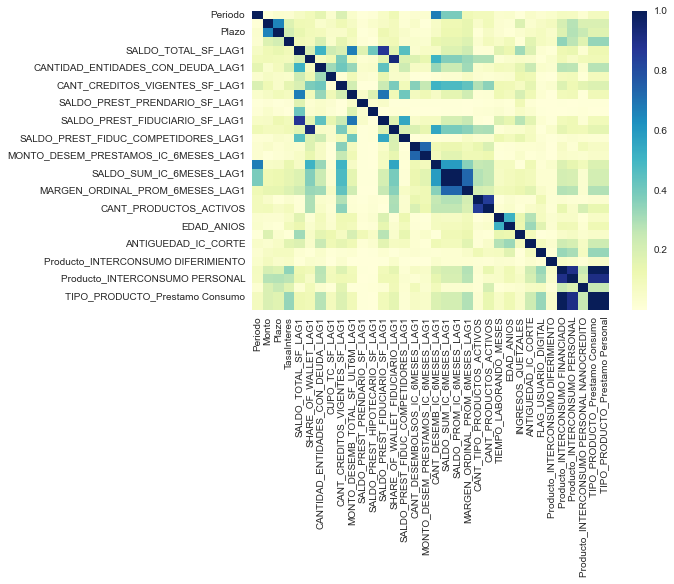

In [55]:
# Heat map de matriz de correlacion, en valor absoluto
data_corr = df_final.corr().abs()
sns.heatmap(data_corr, cmap="YlGnBu")

In [57]:
# Esta es la matriz de correlaciones totales en valor absoluto
data_corr

,Periodo,Monto,Plazo,TasaInteres,SALDO_TOTAL_SF_LAG1,SHARE_OF_WALLET_LAG1,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,CUPO_TC_SF_LAG1,CANT_CREDITOS_VIGENTES_SF_LAG1,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,SALDO_PREST_PRENDARIO_SF_LAG1,SALDO_PREST_HIPOTECARIO_SF_LAG1,SALDO_PREST_FIDUCIARIO_SF_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,CANT_DESEMBOLSOS_IC_6MESES_LAG1,MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1,CANT_DESEMB_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,MARGEN_ORDINAL_PROM_6MESES_LAG1,CANT_TIPO_PRODUCTOS_ACTIVOS,CANT_PRODUCTOS_ACTIVOS,TIEMPO_LABORANDO_MESES,EDAD_ANIOS,INGRESOS_QUETZALES,ANTIGUEDAD_IC_CORTE,FLAG_USUARIO_DIGITAL,Producto_INTERCONSUMO DIFERIMIENTO,Producto_INTERCONSUMO FINANCIADO,Producto_INTERCONSUMO PERSONAL,Producto_INTERCONSUMO PERSONAL NANOCREDITO,TIPO_PRODUCTO_Prestamo Consumo,TIPO_PRODUCTO_Prestamo Personal
Periodo,1.00,0.01,0.04,0.03,0.07,0.10,0.15,0.04,0.19,0.05,0.01,0.01,0.06,0.11,0.02,0.03,0.03,0.67,0.38,0.38,0.11,0.09,0.09,0.04,0.04,0.01,0.05,0.03,0.05,0.08,0.07,0.02,0.08,0.08
Monto,0.01,1.00,0.66,0.18,0.11,0.10,0.04,0.07,0.11,0.07,0.02,0.05,0.07,0.09,0.02,0.05,0.01,0.06,0.12,0.12,0.14,0.05,0.10,0.03,0.02,0.18,0.04,0.07,0.08,0.20,0.28,0.19,0.19,0.19
Plazo,0.04,0.66,1.00,0.21,0.14,0.10,0.09,0.05,0.05,0.10,0.00,0.02,0.12,0.09,0.05,0.03,0.02,0.06,0.12,0.12,0.14,0.01,0.06,0.03,0.01,0.04,0.06,0.08,0.05,0.18,0.28,0.25,0.17,0.17
TasaInteres,0.03,0.18,0.21,1.00,0.10,0.09,0.19,0.05,0.15,0.08,0.01,0.00,0.10,0.11,0.04,0.04,0.03,0.13,0.15,0.15,0.18,0.04,0.09,0.06,0.10,0.01,0.16,0.08,0.06,0.35,0.27,0.17,0.34,0.34
SALDO_TOTAL_SF_LAG1,0.07,0.11,0.14,0.10,1.00,0.20,0.51,0.23,0.19,0.67,0.17,0.41,0.87,0.16,0.45,0.04,0.06,0.07,0.18,0.18,0.23,0.01,0.02,0.17,0.13,0.32,0.18,0.03,0.01,0.12,0.13,0.02,0.12,0.12
SHARE_OF_WALLET_LAG1,0.10,0.10,0.10,0.09,0.20,1.00,0.08,0.12,0.38,0.10,0.02,0.04,0.16,0.93,0.18,0.18,0.14,0.51,0.37,0.37,0.33,0.30,0.29,0.02,0.04,0.06,0.05,0.01,0.04,0.10,0.06,0.10,0.11,0.11
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,0.15,0.04,0.09,0.19,0.51,0.08,1.00,0.32,0.41,0.33,0.05,0.05,0.44,0.06,0.23,0.07,0.06,0.33,0.23,0.23,0.32,0.04,0.06,0.09,0.08,0.15,0.24,0.04,0.03,0.28,0.27,0.04,0.28,0.28
CUPO_TC_SF_LAG1,0.04,0.07,0.05,0.05,0.23,0.12,0.32,1.00,0.02,0.10,0.03,0.02,0.14,0.05,0.05,0.01,0.00,0.02,0.03,0.03,0.06,0.03,0.02,0.03,0.04,0.13,0.11,0.01,0.00,0.09,0.09,0.01,0.09,0.09
CANT_CREDITOS_VIGENTES_SF_LAG1,0.19,0.11,0.05,0.15,0.19,0.38,0.41,0.02,1.00,0.21,0.00,0.00,0.24,0.39,0.10,0.36,0.25,0.51,0.48,0.48,0.43,0.29,0.35,0.12,0.11,0.07,0.15,0.02,0.04,0.18,0.11,0.16,0.18,0.18
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,0.05,0.07,0.10,0.08,0.67,0.10,0.33,0.10,0.21,1.00,0.05,0.18,0.69,0.11,0.41,0.08,0.11,0.06,0.16,0.16,0.22,0.02,0.02,0.12,0.09,0.20,0.11,0.02,0.00,0.10,0.11,0.01,0.10,0.10


In [60]:
# Se crea una funcion para visualizar las variables en pares que tiene alta correlacion
def correlation_columns(data_corr, threshold):
    data_corr = data_corr.abs()
    list_var1 = []
    list_var2 = []
    list_val_corr = []
    for i_corr in data_corr:
        temp_data_corr_column = data_corr[i_corr][data_corr[i_corr]>threshold]
        for i, i_var in enumerate(list(temp_data_corr_column.index)):
            if i_corr!=i_var:
                list_var1.append(i_corr)
                list_var2.append(i_var)
                list_val_corr.append(temp_data_corr_column.values[i])
    return pd.DataFrame(list(zip(list_var1, list_var2, list_val_corr)), columns=['VAR_1', 'VAR_2', 'CORRELATION'])

correlation_columns(data_corr, 0.2).sort_values(by='CORRELATION', ascending=False)

,VAR_1,VAR_2,CORRELATION
123,SALDO_PROM_IC_6MESES_LAG1,SALDO_SUM_IC_6MESES_LAG1,1.00
109,SALDO_SUM_IC_6MESES_LAG1,SALDO_PROM_IC_6MESES_LAG1,1.00
214,TIPO_PRODUCTO_Prestamo Consumo,TIPO_PRODUCTO_Prestamo Personal,1.00
225,TIPO_PRODUCTO_Prestamo Personal,TIPO_PRODUCTO_Prestamo Consumo,1.00
222,TIPO_PRODUCTO_Prestamo Personal,Producto_INTERCONSUMO FINANCIADO,0.99
188,Producto_INTERCONSUMO FINANCIADO,TIPO_PRODUCTO_Prestamo Personal,0.99
211,TIPO_PRODUCTO_Prestamo Consumo,Producto_INTERCONSUMO FINANCIADO,0.99
187,Producto_INTERCONSUMO FINANCIADO,TIPO_PRODUCTO_Prestamo Consumo,0.99
76,SHARE_OF_WALLET_FIDUCIARIO_LAG1,SHARE_OF_WALLET_LAG1,0.93
23,SHARE_OF_WALLET_LAG1,SHARE_OF_WALLET_FIDUCIARIO_LAG1,0.93


In [61]:
# Para este caso solo se observa correlacion entre las variables calculadas como sub universos, por ejemplo
# SALDO_PROM_IC_6MESES_LAG1	SALDO_SUM_IC_6MESES_LAG1	1.00
# 98	SALDO_SUM_IC_6MESES_LAG1	SALDO_PROM_IC_6MESES_LAG1	1.00
# 16	SHARE_OF_WALLET_LAG1	SHARE_OF_WALLET_FIDUCIARIO_LAG1	

In [62]:
df = df_final.select_dtypes(exclude=['datetime64','object'])
df.dtypes

Periodo                                         int32
Monto                                         float64
Plazo                                           int32
TasaInteres                                   float64
SALDO_TOTAL_SF_LAG1                           float32
SHARE_OF_WALLET_LAG1                          float32
CANTIDAD_ENTIDADES_CON_DEUDA_LAG1             float64
CUPO_TC_SF_LAG1                               float32
CANT_CREDITOS_VIGENTES_SF_LAG1                float32
MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1              float32
SALDO_PREST_PRENDARIO_SF_LAG1                 float32
SALDO_PREST_HIPOTECARIO_SF_LAG1               float32
SALDO_PREST_FIDUCIARIO_SF_LAG1                float32
SHARE_OF_WALLET_FIDUCIARIO_LAG1               float32
SALDO_PREST_FIDUC_COMPETIDORES_LAG1           float32
CANT_DESEMBOLSOS_IC_6MESES_LAG1               float32
MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1          float32
CANT_DESEMB_IC_6MESES_LAG1                    float32
SALDO_SUM_IC_6MESES_LAG1    

In [63]:
# Analizamos la correlacion de la variable Target uno a uno con las variables predictoras
list_corr = []
for i_names in df.columns:
    temp_corr = df['TasaInteres'].corr(df[i_names])
    list_corr.append(temp_corr)

# Listamos las variables con correlacion mayor a 0.2 en absoluto
corr_target = pd.DataFrame({'Columns':df.columns, 'Correlacion': list_corr})
corr_target[corr_target['Correlacion'].abs()>0.2]

,Columns,Correlacion
2,Plazo,-0.21
3,TasaInteres,1.00
29,Producto_INTERCONSUMO FINANCIADO,0.35
30,Producto_INTERCONSUMO PERSONAL,-0.27
32,TIPO_PRODUCTO_Prestamo Consumo,0.34
33,TIPO_PRODUCTO_Prestamo Personal,-0.34


In [64]:
# Vemos todas las correlaciones entre las variables predictoras y la target
corr_target

,Columns,Correlacion
0,Periodo,-0.03
1,Monto,-0.18
2,Plazo,-0.21
3,TasaInteres,1.00
4,SALDO_TOTAL_SF_LAG1,-0.10
5,SHARE_OF_WALLET_LAG1,-0.09
6,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,-0.19
7,CUPO_TC_SF_LAG1,-0.05
8,CANT_CREDITOS_VIGENTES_SF_LAG1,-0.15
9,MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1,-0.08


In [65]:
# Configuramos el tamaño de las figuras que se muestran
fig = plt.figure(figsize =(20, 14))

<Figure size 1440x1008 with 0 Axes>

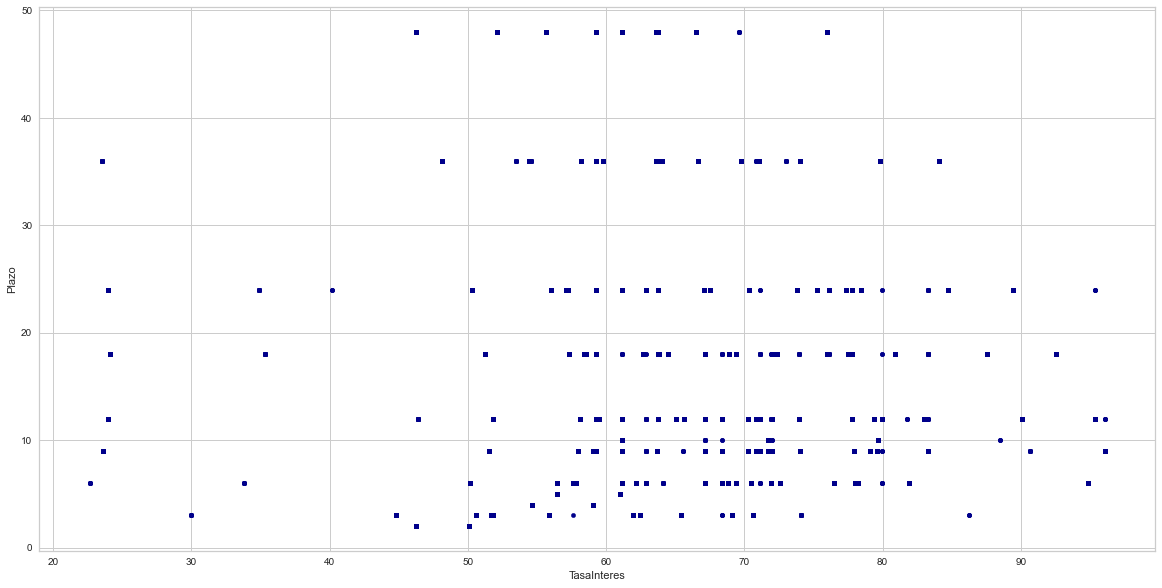

In [66]:
# Visualizamos la TasaInteres vs Plazo según la data que tenemos, para comprobar su correlacion con la target
ax1 = df.plot.scatter(x='TasaInteres', y='Plazo',c='DarkBlue', figsize=(20, 10))

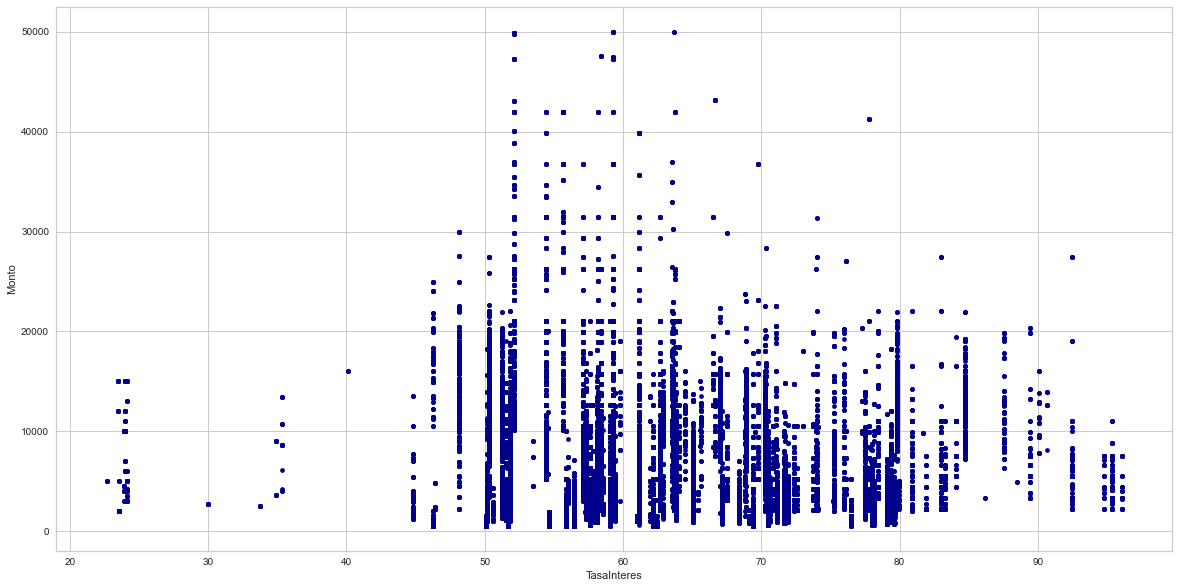

In [67]:
# Visualizamos la Target vs Monto según la data que tenemos, para comprobar su correlacion con la target
ax1 = df.plot.scatter(x='TasaInteres', y='Monto',c='DarkBlue', figsize=(20, 10))

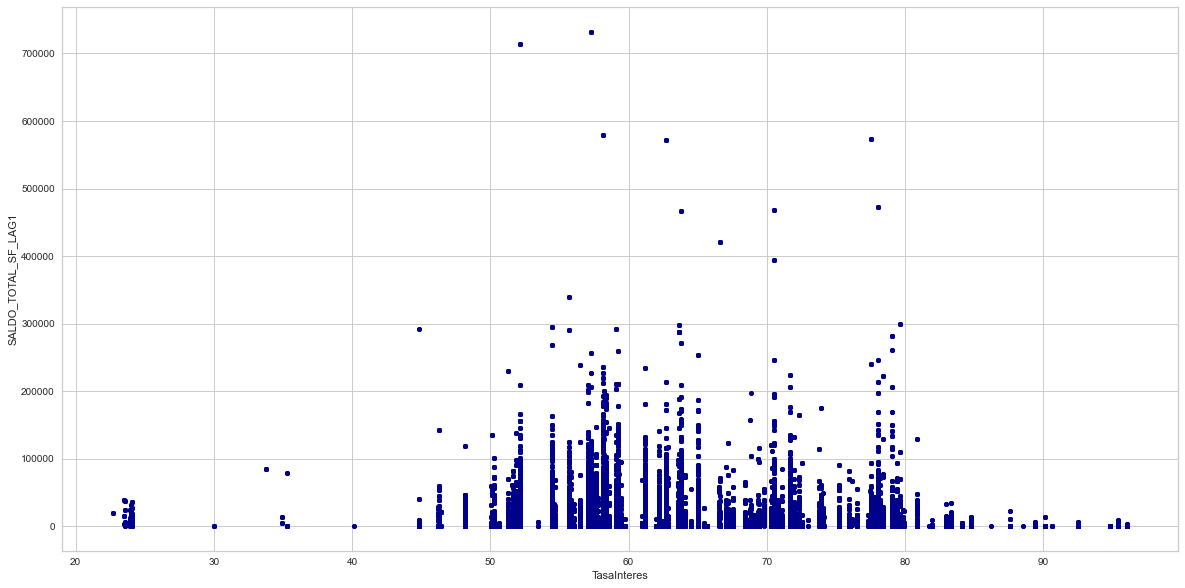

In [68]:
# Visualizamos la Target vs SALDO_TOTAL_SF_LAG1 según la data que tenemos, para comprobar su correlacion con la target
ax1 = df.plot.scatter(x='TasaInteres', y='SALDO_TOTAL_SF_LAG1',c='DarkBlue', figsize=(20, 10))

# Calculando el VIF

In [69]:
# Se crea la funcion para el calculo del VIF
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                              for i in range(len(data.columns))]
    return vif_data.sort_values(by = 'VIF')

In [70]:
df_final.columns

Index(['Periodo', 'IdCliente', 'Monto', 'Estado', 'FechaAlta', 'Plazo',
       'Producto', 'IdPrestamo', 'TipoArticulo', 'TasaInteres',
       'FechaSolicitud', 'TIPO_PRODUCTO', 'Periodo_Fecha', 'fechaSaldos_x',
       'SALDO_TOTAL_SF_LAG1', 'SHARE_OF_WALLET_LAG1',
       'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1', 'CUPO_TC_SF_LAG1',
       'CANT_CREDITOS_VIGENTES_SF_LAG1', 'MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1',
       'SALDO_PREST_PRENDARIO_SF_LAG1', 'SALDO_PREST_HIPOTECARIO_SF_LAG1',
       'SALDO_PREST_FIDUCIARIO_SF_LAG1', 'SHARE_OF_WALLET_FIDUCIARIO_LAG1',
       'SALDO_PREST_FIDUC_COMPETIDORES_LAG1',
       'CANT_DESEMBOLSOS_IC_6MESES_LAG1',
       'MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1', 'CANT_DESEMB_IC_6MESES_LAG1',
       'SALDO_SUM_IC_6MESES_LAG1', 'SALDO_PROM_IC_6MESES_LAG1',
       'MARGEN_ORDINAL_PROM_6MESES_LAG1', 'fechaSaldos_y',
       'CANT_TIPO_PRODUCTOS_ACTIVOS', 'CANT_PRODUCTOS_ACTIVOS',
       'TIEMPO_LABORANDO_MESES', 'EDAD_ANIOS', 'INGRESOS_QUETZALES',
       'ANTIGUEDAD_IC_

In [121]:
# Seteamos las columnas predicotiras para el modelo
cols_modelo = [
#     'Periodo',
               'Monto', 'Plazo',
       'TasaInteres',
#        'SALDO_TOTAL_SF_LAG1', 
    'SHARE_OF_WALLET_LAG1',
       'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1', 'CUPO_TC_SF_LAG1',
       'CANT_CREDITOS_VIGENTES_SF_LAG1', 
#     'MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1',
       'SALDO_PREST_PRENDARIO_SF_LAG1', 'SALDO_PREST_HIPOTECARIO_SF_LAG1',
#        'SALDO_PREST_FIDUCIARIO_SF_LAG1',
#                'SHARE_OF_WALLET_FIDUCIARIO_LAG1',
       'SALDO_PREST_FIDUC_COMPETIDORES_LAG1',
#        'CANT_DESEMBOLSOS_IC_6MESES_LAG1',
#        'MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1',
#                'CANT_DESEMB_IC_6MESES_LAG1',
#        'SALDO_SUM_IC_6MESES_LAG1',
               'SALDO_PROM_IC_6MESES_LAG1',
       'MARGEN_ORDINAL_PROM_6MESES_LAG1', 
#        'CANT_TIPO_PRODUCTOS_ACTIVOS',
               'CANT_PRODUCTOS_ACTIVOS',
       'TIEMPO_LABORANDO_MESES',
#     'EDAD_ANIOS',
    'INGRESOS_QUETZALES',
       'ANTIGUEDAD_IC_CORTE',
    'FLAG_USUARIO_DIGITAL',
       'TIPO_PRODUCTO_Prestamo Consumo'
#                'TIPO_PRODUCTO_Prestamo Personal'
              ]

In [122]:
# Separamos las variables predictoras y la target para correr el modelo
x_columns = cols_modelo
x_columns.remove('TasaInteres')

y_column = ['TasaInteres']

In [123]:
# Verificamos las variables predictoras
print('Cantidad de columans originales:', len(df_final.columns))
print('Cantidad de variables predictoras:',len(x_columns))
print('Verificamos que la variable target no este en la lista:','TasaInteres' in x_columns)
print('Lista de variables predictoras:\n', x_columns)

Cantidad de columans originales: 45
Cantidad de variables predictoras: 17
Verificamos que la variable target no este en la lista: False
Lista de variables predictoras:
 ['Monto', 'Plazo', 'SHARE_OF_WALLET_LAG1', 'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1', 'CUPO_TC_SF_LAG1', 'CANT_CREDITOS_VIGENTES_SF_LAG1', 'SALDO_PREST_PRENDARIO_SF_LAG1', 'SALDO_PREST_HIPOTECARIO_SF_LAG1', 'SALDO_PREST_FIDUC_COMPETIDORES_LAG1', 'SALDO_PROM_IC_6MESES_LAG1', 'MARGEN_ORDINAL_PROM_6MESES_LAG1', 'CANT_PRODUCTOS_ACTIVOS', 'TIEMPO_LABORANDO_MESES', 'INGRESOS_QUETZALES', 'ANTIGUEDAD_IC_CORTE', 'FLAG_USUARIO_DIGITAL', 'TIPO_PRODUCTO_Prestamo Consumo']


In [124]:
# Se muestran los valores del VIF ordenados
df_vif = calculate_vif(df_final[x_columns])
df_vif.sort_values(by='VIF', ascending=False)

,feature,VIF
15,FLAG_USUARIO_DIGITAL,8.76
11,CANT_PRODUCTOS_ACTIVOS,7.17
1,Plazo,6.03
0,Monto,4.16
3,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,4.02
10,MARGEN_ORDINAL_PROM_6MESES_LAG1,3.68
5,CANT_CREDITOS_VIGENTES_SF_LAG1,3.61
13,INGRESOS_QUETZALES,3.55
9,SALDO_PROM_IC_6MESES_LAG1,3.17
16,TIPO_PRODUCTO_Prestamo Consumo,2.77


In [125]:
# Para esta data dummy no se muestra alto VIF
# Alto VIF conservador se puede considerar mayor a 10
# Alto VIF mas estricto se consideraria mayor a 5
# Se realizaria un proceso iterativo hasta dejar solo las variables predictoras menores a 10 o 5

In [126]:
# Nos quedamos con las variables con VIF menores a 10, bajo un escenario conservador
df_vif_menor_10 = df_vif[df_vif['VIF']<10]
df_vif_menor_10

,feature,VIF
7,SALDO_PREST_HIPOTECARIO_SF_LAG1,1.01
6,SALDO_PREST_PRENDARIO_SF_LAG1,1.02
4,CUPO_TC_SF_LAG1,1.19
8,SALDO_PREST_FIDUC_COMPETIDORES_LAG1,1.19
12,TIEMPO_LABORANDO_MESES,2.41
14,ANTIGUEDAD_IC_CORTE,2.53
2,SHARE_OF_WALLET_LAG1,2.63
16,TIPO_PRODUCTO_Prestamo Consumo,2.77
9,SALDO_PROM_IC_6MESES_LAG1,3.17
13,INGRESOS_QUETZALES,3.55


In [127]:
# Listamos los nombres de las variables
df_vif_menor_10['feature'].values

array(['SALDO_PREST_HIPOTECARIO_SF_LAG1', 'SALDO_PREST_PRENDARIO_SF_LAG1',
       'CUPO_TC_SF_LAG1', 'SALDO_PREST_FIDUC_COMPETIDORES_LAG1',
       'TIEMPO_LABORANDO_MESES', 'ANTIGUEDAD_IC_CORTE',
       'SHARE_OF_WALLET_LAG1', 'TIPO_PRODUCTO_Prestamo Consumo',
       'SALDO_PROM_IC_6MESES_LAG1', 'INGRESOS_QUETZALES',
       'CANT_CREDITOS_VIGENTES_SF_LAG1',
       'MARGEN_ORDINAL_PROM_6MESES_LAG1',
       'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1', 'Monto', 'Plazo',
       'CANT_PRODUCTOS_ACTIVOS', 'FLAG_USUARIO_DIGITAL'], dtype=object)

In [128]:
# Preparamos la data para el modelo
X = df_final[df_vif_menor_10['feature'].values].values
y = df_final[y_column].values

In [129]:
# Escalamos las variables a un rango de 0 a 1
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_x.fit(X)
X_scaler = scaler_x.transform(X)

scaler_y = MinMaxScaler(feature_range = (0, 1))
scaler_y.fit(y)
y_scaler = scaler_y.transform(y)
y_scaler = y_scaler.reshape(y_scaler.shape[0])


In [130]:
# Verificamos el cambio realizado
print('X_max:', X_scaler.max(axis=0),',Y_max:', y_scaler.max(axis=0))
print('X_min:', X_scaler.min(axis=0),',Y_min:', y_scaler.min(axis=0))

X_max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] ,Y_max: 1.0
X_min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ,Y_min: 0.0


In [131]:
# Separamos la data de train y test
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y_scaler, test_size=0.3, random_state=42)
print('X:', X_scaler.shape, ',y:', y_scaler.shape)
print('X_train:', X_train.shape, ',y_train:', y_train.shape, ',X_test:', X_test.shape, ',y_test:', y_test.shape)

X: (167291, 17) ,y: (167291,)
X_train: (117103, 17) ,y_train: (117103,) ,X_test: (50188, 17) ,y_test: (50188,)


# Modelo 1: Lasso Regression

In [132]:
# Generamos el Grid Search para el tuneo de hiperparametros
# search = GridSearchCV(Lasso(),
#                       {'alpha':np.arange(0.0001,1,0.0005)},
#                       cv = 10, scoring="neg_mean_squared_error",verbose=3
#                       )

# Prueba para la data dummy
search = GridSearchCV(Lasso(),
                      {'alpha':np.arange(0.001,1,0.05)},
                      cv = 10, scoring="neg_mean_squared_error",verbose=3
                      )

In [133]:
# Ejecutamos el grid search
search.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10] END .....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 2/10] END .....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 3/10] END .....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 4/10] END .....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 5/10] END .....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 6/10] END .....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 7/10] END .....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 8/10] END .....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 9/10] END .....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 10/10] END ....................alpha=0.001;, score=-0.011 total time=   0.0s
[CV 1/10] END ......alpha=0.051000000000000004;, score=-0.013 total time=   0.0s
[CV 2/10] END ......alpha=0.051000000000000004

[CV 2/10] END .....................alpha=0.501;, score=-0.013 total time=   0.0s
[CV 3/10] END .....................alpha=0.501;, score=-0.013 total time=   0.0s
[CV 4/10] END .....................alpha=0.501;, score=-0.013 total time=   0.0s
[CV 5/10] END .....................alpha=0.501;, score=-0.013 total time=   0.0s
[CV 6/10] END .....................alpha=0.501;, score=-0.013 total time=   0.0s
[CV 7/10] END .....................alpha=0.501;, score=-0.013 total time=   0.0s
[CV 8/10] END .....................alpha=0.501;, score=-0.013 total time=   0.0s
[CV 9/10] END .....................alpha=0.501;, score=-0.013 total time=   0.0s
[CV 10/10] END ....................alpha=0.501;, score=-0.013 total time=   0.0s
[CV 1/10] END .....................alpha=0.551;, score=-0.013 total time=   0.0s
[CV 2/10] END .....................alpha=0.551;, score=-0.013 total time=   0.0s
[CV 3/10] END .....................alpha=0.551;, score=-0.013 total time=   0.0s
[CV 4/10] END ..............

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': array([0.001, 0.051, 0.101, 0.151, 0.201, 0.251, 0.301, 0.351, 0.401,
       0.451, 0.501, 0.551, 0.601, 0.651, 0.701, 0.751, 0.801, 0.851,
       0.901, 0.951])},
             scoring='neg_mean_squared_error', verbose=3)

In [134]:
# Identificamos el modelo con mejor parametro
search.best_params_

{'alpha': 0.001}

In [135]:
# Visualizamos los coeficientes en valor absoluto del modelo con mejor parametro
coefficients = search.best_estimator_.coef_
importance = np.abs(coefficients)
importance

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02556584, 0.01248283, 0.06359828, 0.        , 0.        ,
       0.        , 0.        , 0.03068337, 0.        , 0.07069335,
       0.        , 0.        ])

In [136]:
# Listamos las variables ordenadas por el valor absoluto de sus coeficientes
df_importance = pd.DataFrame(zip(df_vif_menor_10['feature'].values, importance))
df_importance.sort_values(by=1, ascending=False)

,0,1
14,Plazo,0.07
7,TIPO_PRODUCTO_Prestamo Consumo,0.06
12,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,0.03
5,ANTIGUEDAD_IC_CORTE,0.03
6,SHARE_OF_WALLET_LAG1,0.01
0,SALDO_PREST_HIPOTECARIO_SF_LAG1,0.00
10,CANT_CREDITOS_VIGENTES_SF_LAG1,0.00
15,CANT_PRODUCTOS_ACTIVOS,0.00
13,Monto,0.00
11,MARGEN_ORDINAL_PROM_6MESES_LAG1,0.00


In [137]:
# Visualizamos los coeficientes del modelo con mejor parametro
coefficients = search.best_estimator_.coef_
importance = coefficients
importance

array([ 0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.02556584, -0.01248283,  0.06359828, -0.        ,  0.        ,
       -0.        , -0.        , -0.03068337, -0.        , -0.07069335,
       -0.        , -0.        ])

In [138]:
# Listamos las variables con coeficiente distinto a 0, es decir las mas importantes segun este modelo
df_importance = pd.DataFrame(zip(df_vif_menor_10['feature'].values, importance))
df_importance[df_importance[1]!=0].sort_values(by=1, ascending=False)

,0,1
7,TIPO_PRODUCTO_Prestamo Consumo,0.06
6,SHARE_OF_WALLET_LAG1,-0.01
5,ANTIGUEDAD_IC_CORTE,-0.03
12,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,-0.03
14,Plazo,-0.07


In [139]:
# Calculamos el R2 con el metodo de la libreria, para la data de train
search.best_estimator_.score(X_train, y_train)

0.15061917744627862

In [140]:
# Calculamos el R2 con la funcion especifica, para la data de train
y_pred = search.best_estimator_.predict(X_train)
r2_score(y_train, y_pred)

0.15061917744627862

In [141]:
# Calulamos el RMSE, para la data de train
mean_squared_error(y_train, y_pred)**0.5

0.10533900024794177

In [142]:
# Calculamos el R2 con el metodo de la libreria, para la data de test
search.best_estimator_.score(X_test, y_test)

0.15688786505995533

In [143]:
# Calculamos el R2 con la funcion especifica, para la data de test
y_pred = search.best_estimator_.predict(X_test)
r2_score(y_test, y_pred)

0.15688786505995533

In [144]:
# Calulamos el RMSE, para la data de test
mean_squared_error(y_test, y_pred)**0.5

0.10509079522998463

In [145]:
# Volvemos a entrenar el modelo de Lasso con el mejor parametro
best_model = Lasso(alpha=search.best_params_['alpha'])
best_model.fit(X_train, y_train)
coef_best_model = best_model.coef_

In [146]:
# Verificamos que los coeficientes sean los mismos que se obtuvieron anteriormente
print('Coeficientes del ultimo modelo:\n', coef_best_model)
print('\nCoeficientes del modelo entrenado previamente:\n', importance)

Coeficientes del ultimo modelo:
 [ 0.          0.         -0.         -0.         -0.         -0.02556584
 -0.01248283  0.06359828 -0.          0.         -0.         -0.
 -0.03068337 -0.         -0.07069335 -0.         -0.        ]

Coeficientes del modelo entrenado previamente:
 [ 0.          0.         -0.         -0.         -0.         -0.02556584
 -0.01248283  0.06359828 -0.          0.         -0.         -0.
 -0.03068337 -0.         -0.07069335 -0.         -0.        ]


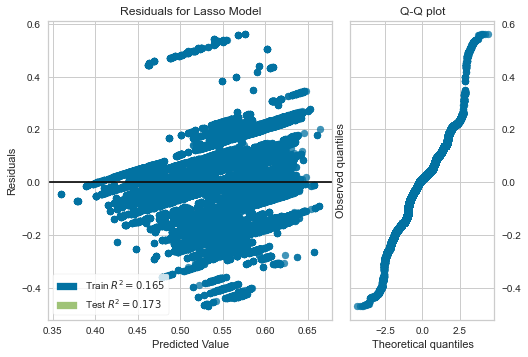

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [147]:
# Usamos la libreria yellowbrick para poder hacer el analisis de residuales usando el mejor parametro, en la data de train
visualizer = ResidualsPlot(Lasso(alpha=0.0001), hist=False, qqplot=True, test_alpha=0)
visualizer.fit(X_train, y_train.reshape(y_train.shape[0]))
visualizer.score(X_test, y_test.reshape(y_test.shape[0]))
visualizer.show()

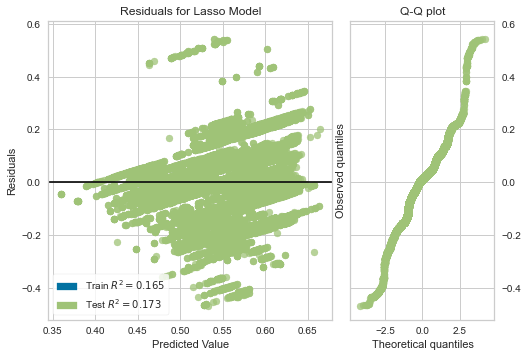

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [148]:
# Usamos la libreria yellowbrick para poder hacer el analisis de residuales usando el mejor parametro, en la data de test
visualizer = ResidualsPlot(Lasso(alpha=0.0001), hist=False, qqplot=True, train_alpha=0)
visualizer.fit(X_train, y_train.reshape(y_train.shape[0]))
visualizer.score(X_test, y_test.reshape(y_test.shape[0]))
visualizer.show()

# Modelo 2: Random Forest Regressor

In [149]:
# Seteamos las columnas predicotiras para el modelo
cols_modelo_tree = [
#     'Periodo',
               'Monto', 'Plazo',
       'TasaInteres',
       'SALDO_TOTAL_SF_LAG1', 
    'SHARE_OF_WALLET_LAG1',
       'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1', 'CUPO_TC_SF_LAG1',
       'CANT_CREDITOS_VIGENTES_SF_LAG1', 
    'MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1',
       'SALDO_PREST_PRENDARIO_SF_LAG1', 'SALDO_PREST_HIPOTECARIO_SF_LAG1',
#        'SALDO_PREST_FIDUCIARIO_SF_LAG1',
#                'SHARE_OF_WALLET_FIDUCIARIO_LAG1',
       'SALDO_PREST_FIDUC_COMPETIDORES_LAG1',
#        'CANT_DESEMBOLSOS_IC_6MESES_LAG1',
#        'MONTO_DESEM_PRESTAMOS_IC_6MESES_LAG1',
#                'CANT_DESEMB_IC_6MESES_LAG1',
#        'SALDO_SUM_IC_6MESES_LAG1',
               'SALDO_PROM_IC_6MESES_LAG1',
       'MARGEN_ORDINAL_PROM_6MESES_LAG1', 
#        'CANT_TIPO_PRODUCTOS_ACTIVOS',
               'CANT_PRODUCTOS_ACTIVOS',
       'TIEMPO_LABORANDO_MESES',
    'EDAD_ANIOS',
    'INGRESOS_QUETZALES',
       'ANTIGUEDAD_IC_CORTE',
    'FLAG_USUARIO_DIGITAL',
       'TIPO_PRODUCTO_Prestamo Consumo'
#                'TIPO_PRODUCTO_Prestamo Personal'
              ]

In [150]:
# Separamos las variables predictoras y la target para correr el modelo
x_columns = cols_modelo_tree
x_columns.remove('TasaInteres')

y_column = ['TasaInteres']

In [151]:
# Verificamos las variables predictoras
print('Cantidad de columans originales:', len(df_final.columns))
print('Cantidad de variables predictoras:',len(x_columns))
print('Verificamos que la variable target no este en la lista:','TasaInteres' in x_columns)
print('Lista de variables predictoras:\n', x_columns)

Cantidad de columans originales: 45
Cantidad de variables predictoras: 20
Verificamos que la variable target no este en la lista: False
Lista de variables predictoras:
 ['Monto', 'Plazo', 'SALDO_TOTAL_SF_LAG1', 'SHARE_OF_WALLET_LAG1', 'CANTIDAD_ENTIDADES_CON_DEUDA_LAG1', 'CUPO_TC_SF_LAG1', 'CANT_CREDITOS_VIGENTES_SF_LAG1', 'MONTO_DESEMB_TOTAL_SF_ULT6M_LAG1', 'SALDO_PREST_PRENDARIO_SF_LAG1', 'SALDO_PREST_HIPOTECARIO_SF_LAG1', 'SALDO_PREST_FIDUC_COMPETIDORES_LAG1', 'SALDO_PROM_IC_6MESES_LAG1', 'MARGEN_ORDINAL_PROM_6MESES_LAG1', 'CANT_PRODUCTOS_ACTIVOS', 'TIEMPO_LABORANDO_MESES', 'EDAD_ANIOS', 'INGRESOS_QUETZALES', 'ANTIGUEDAD_IC_CORTE', 'FLAG_USUARIO_DIGITAL', 'TIPO_PRODUCTO_Prestamo Consumo']


In [152]:
# Preparamos la data para el modelo
X = df_final[x_columns].values
y = df_final[y_column].values

In [153]:
# Escalamos las variables a un rango de 0 a 1
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_x.fit(X)
X_scaler = scaler_x.transform(X)

scaler_y = MinMaxScaler(feature_range = (0, 1))
scaler_y.fit(y)
y_scaler = scaler_y.transform(y)
y_scaler = y_scaler.reshape(y_scaler.shape[0])


In [154]:
# Verificamos el cambio realizado
print('X_max:', X_scaler.max(axis=0),',Y_max:', y_scaler.max(axis=0))
print('X_min:', X_scaler.min(axis=0),',Y_min:', y_scaler.min(axis=0))

X_max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] ,Y_max: 1.0
X_min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ,Y_min: 0.0


In [155]:
# Separamos la data de train y test
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y_scaler, test_size=0.3, random_state=42)
print('X:', X_scaler.shape, ',y:', y_scaler.shape)
print('X_train:', X_train.shape, ',y_train:', y_train.shape, ',X_test:', X_test.shape, ',y_test:', y_test.shape)

X: (167291, 20) ,y: (167291,)
X_train: (117103, 20) ,y_train: (117103,) ,X_test: (50188, 20) ,y_test: (50188,)


In [183]:
# Creamos el grid Search 
# search = GridSearchCV(RandomForestRegressor(),
#                       {'n_estimators':np.arange(5,21,1),
#                       'criterion': ['mse'],
#                       'max_depth': [5,8,10],
#                       'min_samples_split': [2,4,6],
#                       'min_samples_leaf': [1,3,5]},
#                       cv = 10, scoring="neg_mean_squared_error",verbose=3
#                       )

# Prueba para la data dummy
search = GridSearchCV(RandomForestRegressor(),
                      {'n_estimators':np.arange(19,31,1),
                      'criterion': ['mse'],
                      'max_depth': [8,10,12,15],
                       'min_samples_leaf': [3,5,10]
                      },
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [184]:
# Ejecutamos el grid search
search.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END criterion=mse, max_depth=8, min_samples_leaf=3, n_estimators=19;, score=-0.007 total time=   4.0s
[CV 2/5] END criterion=mse, max_depth=8, min_samples_leaf=3, n_estimators=19;, score=-0.006 total time=   3.6s
[CV 3/5] END criterion=mse, max_depth=8, min_samples_leaf=3, n_estimators=19;, score=-0.006 total time=   3.7s
[CV 4/5] END criterion=mse, max_depth=8, min_samples_leaf=3, n_estimators=19;, score=-0.007 total time=   3.7s
[CV 5/5] END criterion=mse, max_depth=8, min_samples_leaf=3, n_estimators=19;, score=-0.007 total time=   4.0s
[CV 1/5] END criterion=mse, max_depth=8, min_samples_leaf=3, n_estimators=20;, score=-0.007 total time=   4.4s
[CV 2/5] END criterion=mse, max_depth=8, min_samples_leaf=3, n_estimators=20;, score=-0.006 total time=   3.8s
[CV 3/5] END criterion=mse, max_depth=8, min_samples_leaf=3, n_estimators=20;, score=-0.006 total time=   5.2s
[CV 4/5] END criterion=mse, max_depth=8, min_samp

[CV 5/5] END criterion=mse, max_depth=8, min_samples_leaf=5, n_estimators=21;, score=-0.007 total time=   4.1s
[CV 1/5] END criterion=mse, max_depth=8, min_samples_leaf=5, n_estimators=22;, score=-0.007 total time=   4.2s
[CV 2/5] END criterion=mse, max_depth=8, min_samples_leaf=5, n_estimators=22;, score=-0.006 total time=   4.3s
[CV 3/5] END criterion=mse, max_depth=8, min_samples_leaf=5, n_estimators=22;, score=-0.006 total time=   4.3s
[CV 4/5] END criterion=mse, max_depth=8, min_samples_leaf=5, n_estimators=22;, score=-0.007 total time=   4.2s
[CV 5/5] END criterion=mse, max_depth=8, min_samples_leaf=5, n_estimators=22;, score=-0.007 total time=   4.2s
[CV 1/5] END criterion=mse, max_depth=8, min_samples_leaf=5, n_estimators=23;, score=-0.007 total time=   4.5s
[CV 2/5] END criterion=mse, max_depth=8, min_samples_leaf=5, n_estimators=23;, score=-0.006 total time=   4.5s
[CV 3/5] END criterion=mse, max_depth=8, min_samples_leaf=5, n_estimators=23;, score=-0.006 total time=   4.4s
[

[CV 4/5] END criterion=mse, max_depth=8, min_samples_leaf=10, n_estimators=24;, score=-0.007 total time=   4.7s
[CV 5/5] END criterion=mse, max_depth=8, min_samples_leaf=10, n_estimators=24;, score=-0.007 total time=   4.7s
[CV 1/5] END criterion=mse, max_depth=8, min_samples_leaf=10, n_estimators=25;, score=-0.007 total time=   4.9s
[CV 2/5] END criterion=mse, max_depth=8, min_samples_leaf=10, n_estimators=25;, score=-0.007 total time=   4.9s
[CV 3/5] END criterion=mse, max_depth=8, min_samples_leaf=10, n_estimators=25;, score=-0.007 total time=   4.9s
[CV 4/5] END criterion=mse, max_depth=8, min_samples_leaf=10, n_estimators=25;, score=-0.007 total time=   4.8s
[CV 5/5] END criterion=mse, max_depth=8, min_samples_leaf=10, n_estimators=25;, score=-0.007 total time=   4.7s
[CV 1/5] END criterion=mse, max_depth=8, min_samples_leaf=10, n_estimators=26;, score=-0.007 total time=   5.0s
[CV 2/5] END criterion=mse, max_depth=8, min_samples_leaf=10, n_estimators=26;, score=-0.007 total time=

[CV 3/5] END criterion=mse, max_depth=10, min_samples_leaf=3, n_estimators=27;, score=-0.006 total time=   6.2s
[CV 4/5] END criterion=mse, max_depth=10, min_samples_leaf=3, n_estimators=27;, score=-0.006 total time=   6.5s
[CV 5/5] END criterion=mse, max_depth=10, min_samples_leaf=3, n_estimators=27;, score=-0.006 total time=   6.1s
[CV 1/5] END criterion=mse, max_depth=10, min_samples_leaf=3, n_estimators=28;, score=-0.006 total time=   6.9s
[CV 2/5] END criterion=mse, max_depth=10, min_samples_leaf=3, n_estimators=28;, score=-0.006 total time=   6.5s
[CV 3/5] END criterion=mse, max_depth=10, min_samples_leaf=3, n_estimators=28;, score=-0.006 total time=   6.6s
[CV 4/5] END criterion=mse, max_depth=10, min_samples_leaf=3, n_estimators=28;, score=-0.006 total time=   6.7s
[CV 5/5] END criterion=mse, max_depth=10, min_samples_leaf=3, n_estimators=28;, score=-0.006 total time=   6.6s
[CV 1/5] END criterion=mse, max_depth=10, min_samples_leaf=3, n_estimators=29;, score=-0.006 total time=

[CV 2/5] END criterion=mse, max_depth=10, min_samples_leaf=5, n_estimators=30;, score=-0.006 total time=   8.9s
[CV 3/5] END criterion=mse, max_depth=10, min_samples_leaf=5, n_estimators=30;, score=-0.006 total time=   8.8s
[CV 4/5] END criterion=mse, max_depth=10, min_samples_leaf=5, n_estimators=30;, score=-0.006 total time=   9.0s
[CV 5/5] END criterion=mse, max_depth=10, min_samples_leaf=5, n_estimators=30;, score=-0.006 total time=   8.6s
[CV 1/5] END criterion=mse, max_depth=10, min_samples_leaf=10, n_estimators=19;, score=-0.006 total time=   5.6s
[CV 2/5] END criterion=mse, max_depth=10, min_samples_leaf=10, n_estimators=19;, score=-0.006 total time=   5.4s
[CV 3/5] END criterion=mse, max_depth=10, min_samples_leaf=10, n_estimators=19;, score=-0.006 total time=   5.7s
[CV 4/5] END criterion=mse, max_depth=10, min_samples_leaf=10, n_estimators=19;, score=-0.006 total time=   5.7s
[CV 5/5] END criterion=mse, max_depth=10, min_samples_leaf=10, n_estimators=19;, score=-0.006 total 

[CV 5/5] END criterion=mse, max_depth=12, min_samples_leaf=3, n_estimators=20;, score=-0.005 total time=   6.8s
[CV 1/5] END criterion=mse, max_depth=12, min_samples_leaf=3, n_estimators=21;, score=-0.005 total time=   6.9s
[CV 2/5] END criterion=mse, max_depth=12, min_samples_leaf=3, n_estimators=21;, score=-0.005 total time=   6.8s
[CV 3/5] END criterion=mse, max_depth=12, min_samples_leaf=3, n_estimators=21;, score=-0.005 total time=   7.1s
[CV 4/5] END criterion=mse, max_depth=12, min_samples_leaf=3, n_estimators=21;, score=-0.005 total time=   7.2s
[CV 5/5] END criterion=mse, max_depth=12, min_samples_leaf=3, n_estimators=21;, score=-0.005 total time=   7.2s
[CV 1/5] END criterion=mse, max_depth=12, min_samples_leaf=3, n_estimators=22;, score=-0.005 total time=   7.4s
[CV 2/5] END criterion=mse, max_depth=12, min_samples_leaf=3, n_estimators=22;, score=-0.005 total time=   7.4s
[CV 3/5] END criterion=mse, max_depth=12, min_samples_leaf=3, n_estimators=22;, score=-0.005 total time=

[CV 4/5] END criterion=mse, max_depth=12, min_samples_leaf=5, n_estimators=23;, score=-0.005 total time=   6.3s
[CV 5/5] END criterion=mse, max_depth=12, min_samples_leaf=5, n_estimators=23;, score=-0.005 total time=   6.3s
[CV 1/5] END criterion=mse, max_depth=12, min_samples_leaf=5, n_estimators=24;, score=-0.005 total time=   6.5s
[CV 2/5] END criterion=mse, max_depth=12, min_samples_leaf=5, n_estimators=24;, score=-0.005 total time=   6.4s
[CV 3/5] END criterion=mse, max_depth=12, min_samples_leaf=5, n_estimators=24;, score=-0.005 total time=   6.6s
[CV 4/5] END criterion=mse, max_depth=12, min_samples_leaf=5, n_estimators=24;, score=-0.005 total time=   6.4s
[CV 5/5] END criterion=mse, max_depth=12, min_samples_leaf=5, n_estimators=24;, score=-0.005 total time=   6.8s
[CV 1/5] END criterion=mse, max_depth=12, min_samples_leaf=5, n_estimators=25;, score=-0.005 total time=   6.8s
[CV 2/5] END criterion=mse, max_depth=12, min_samples_leaf=5, n_estimators=25;, score=-0.005 total time=

[CV 2/5] END criterion=mse, max_depth=12, min_samples_leaf=10, n_estimators=26;, score=-0.005 total time=   7.1s
[CV 3/5] END criterion=mse, max_depth=12, min_samples_leaf=10, n_estimators=26;, score=-0.005 total time=   7.3s
[CV 4/5] END criterion=mse, max_depth=12, min_samples_leaf=10, n_estimators=26;, score=-0.005 total time=   7.0s
[CV 5/5] END criterion=mse, max_depth=12, min_samples_leaf=10, n_estimators=26;, score=-0.005 total time=   7.4s
[CV 1/5] END criterion=mse, max_depth=12, min_samples_leaf=10, n_estimators=27;, score=-0.005 total time=   7.7s
[CV 2/5] END criterion=mse, max_depth=12, min_samples_leaf=10, n_estimators=27;, score=-0.005 total time=   7.4s
[CV 3/5] END criterion=mse, max_depth=12, min_samples_leaf=10, n_estimators=27;, score=-0.005 total time=   7.5s
[CV 4/5] END criterion=mse, max_depth=12, min_samples_leaf=10, n_estimators=27;, score=-0.005 total time=   7.6s
[CV 5/5] END criterion=mse, max_depth=12, min_samples_leaf=10, n_estimators=27;, score=-0.005 to

[CV 5/5] END criterion=mse, max_depth=15, min_samples_leaf=3, n_estimators=28;, score=-0.004 total time=   9.1s
[CV 1/5] END criterion=mse, max_depth=15, min_samples_leaf=3, n_estimators=29;, score=-0.004 total time=   9.5s
[CV 2/5] END criterion=mse, max_depth=15, min_samples_leaf=3, n_estimators=29;, score=-0.003 total time=   9.5s
[CV 3/5] END criterion=mse, max_depth=15, min_samples_leaf=3, n_estimators=29;, score=-0.004 total time=   9.5s
[CV 4/5] END criterion=mse, max_depth=15, min_samples_leaf=3, n_estimators=29;, score=-0.004 total time=   9.3s
[CV 5/5] END criterion=mse, max_depth=15, min_samples_leaf=3, n_estimators=29;, score=-0.004 total time=   9.3s
[CV 1/5] END criterion=mse, max_depth=15, min_samples_leaf=3, n_estimators=30;, score=-0.004 total time=   9.5s
[CV 2/5] END criterion=mse, max_depth=15, min_samples_leaf=3, n_estimators=30;, score=-0.003 total time=   9.7s
[CV 3/5] END criterion=mse, max_depth=15, min_samples_leaf=3, n_estimators=30;, score=-0.003 total time=

[CV 4/5] END criterion=mse, max_depth=15, min_samples_leaf=10, n_estimators=19;, score=-0.004 total time=   5.8s
[CV 5/5] END criterion=mse, max_depth=15, min_samples_leaf=10, n_estimators=19;, score=-0.004 total time=   6.0s
[CV 1/5] END criterion=mse, max_depth=15, min_samples_leaf=10, n_estimators=20;, score=-0.004 total time=   6.2s
[CV 2/5] END criterion=mse, max_depth=15, min_samples_leaf=10, n_estimators=20;, score=-0.004 total time=   6.1s
[CV 3/5] END criterion=mse, max_depth=15, min_samples_leaf=10, n_estimators=20;, score=-0.004 total time=   6.5s
[CV 4/5] END criterion=mse, max_depth=15, min_samples_leaf=10, n_estimators=20;, score=-0.004 total time=   6.5s
[CV 5/5] END criterion=mse, max_depth=15, min_samples_leaf=10, n_estimators=20;, score=-0.004 total time=   6.4s
[CV 1/5] END criterion=mse, max_depth=15, min_samples_leaf=10, n_estimators=21;, score=-0.004 total time=   6.5s
[CV 2/5] END criterion=mse, max_depth=15, min_samples_leaf=10, n_estimators=21;, score=-0.004 to

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse'], 'max_depth': [8, 10, 12, 15],
                         'min_samples_leaf': [3, 5, 10],
                         'n_estimators': array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
             scoring='neg_mean_squared_error', verbose=3)

In [185]:
# Identificamos el modelo con mejores parametros
search.best_params_

{'criterion': 'mse',
 'max_depth': 15,
 'min_samples_leaf': 3,
 'n_estimators': 27}

In [195]:
# Obtenemos la importancia de las variables predictoras del modelo con mejores parametros
importance = search.best_estimator_.feature_importances_
importance

array([8.78968075e-02, 2.86351653e-01, 2.78029619e-02, 7.42461946e-03,
       6.95702270e-03, 1.36713642e-02, 1.08649745e-02, 1.50782187e-02,
       1.19780854e-04, 8.81196211e-05, 6.18918127e-03, 2.25120531e-02,
       2.58664058e-02, 5.61328968e-03, 3.27808123e-02, 3.67575686e-02,
       4.27329473e-02, 2.11921725e-01, 1.12236420e-03, 1.58248130e-01])

Feature: 0, Score: 0.08790
Feature: 1, Score: 0.28635
Feature: 2, Score: 0.02780
Feature: 3, Score: 0.00742
Feature: 4, Score: 0.00696
Feature: 5, Score: 0.01367
Feature: 6, Score: 0.01086
Feature: 7, Score: 0.01508
Feature: 8, Score: 0.00012
Feature: 9, Score: 0.00009
Feature: 10, Score: 0.00619
Feature: 11, Score: 0.02251
Feature: 12, Score: 0.02587
Feature: 13, Score: 0.00561
Feature: 14, Score: 0.03278
Feature: 15, Score: 0.03676
Feature: 16, Score: 0.04273
Feature: 17, Score: 0.21192
Feature: 18, Score: 0.00112
Feature: 19, Score: 0.15825


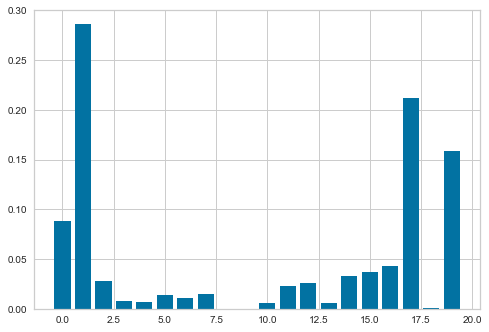

In [196]:
# Visualizamos las importancias de las variables predictoras del modelo con mejores parametros
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [197]:
# Visualizamos las variables del modelo con mejores parametros, ordenadas segun su importancia
df_importance = pd.DataFrame(zip(df_vif_menor_10['feature'].values, importance))
df_importance[1] = df_importance[1]*100
df_importance.sort_values(by=1, ascending=False)

,0,1
1,SALDO_PREST_PRENDARIO_SF_LAG1,28.64
0,SALDO_PREST_HIPOTECARIO_SF_LAG1,8.79
16,FLAG_USUARIO_DIGITAL,4.27
15,CANT_PRODUCTOS_ACTIVOS,3.68
14,Plazo,3.28
2,CUPO_TC_SF_LAG1,2.78
12,CANTIDAD_ENTIDADES_CON_DEUDA_LAG1,2.59
11,MARGEN_ORDINAL_PROM_6MESES_LAG1,2.25
7,TIPO_PRODUCTO_Prestamo Consumo,1.51
5,ANTIGUEDAD_IC_CORTE,1.37


In [198]:
# Calculamos el R2 con el metodo de la libreria, para la data de train
search.best_estimator_.score(X_train, y_train)

0.7778293148319588

In [199]:
# Calculamos el R2 con la funcion especifica, para la data de train
y_pred = search.best_estimator_.predict(X_train)
r2_score(y_train, y_pred)

0.7778293148319588

In [200]:
# Calulamos el RMSE, para la data de train
mean_squared_error(y_train, y_pred)**0.5

0.05387426321914455

In [201]:
# Calculamos el R2 con el metodo de la libreria, para la data de test
search.best_estimator_.score(X_test, y_test)

0.7423937307652388

In [202]:
# Calculamos el R2 con la funcion especifica, para la data de test
y_pred = search.best_estimator_.predict(X_test)
r2_score(y_test, y_pred)

0.7423937307652388

In [203]:
# Calulamos el RMSE, para la data de test
mean_squared_error(y_test, y_pred)**0.5

0.058089845623579446

In [206]:
# consume_time = time.time() - time_start
# print("Tiempo consumido: ", round(consume_time/60,2), " minutos")